# Учимся обыгрывать казино: RL с блекджеком и Дастином Хоффманом.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.  

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym: 
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;  
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть __usable ace__), и за 1 очко, если превосходит;  
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
* игрок может совершать одно из двух действий:  
  - __hit__  — взять ещё одну карту;  
  - __stand__ — не брать больше карт;  
* если сумма очков у игрока на руках больше 21, он проигрывает (__bust__);  
* если игрок выбирает __stand__ с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);  
* в исходных правилах есть ещё дополнительный бонус за __natural blackjack__: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).  
  
Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('figure', **{'dpi': 300})


import gym
import optuna

In [2]:
class Agent:
    def __init__(self, action_size):
        pass 

    def act(self, state):
        pass


class ThresholdAgent(Agent):
    def __init__(self, action_size, threshold):
        super().__init__(action_size)
        self.threshold = threshold
        self.action_size = action_size
    
    def act(self, state):
        if state[0] < self.threshold:
            action = 1
        else:
            action = 0
        return action
    
    
class EpsilonGreedyAgent(Agent):
    def __init__(self, action_size, agent, eps=0.1):
        super().__init__(action_size)
        self.agent = agent
        self.eps = eps
        self.action_size = action_size

    def act(self, state):
        if random.random() < self.eps:
            return random.randint(self.action_size)
        else:
            return self.agent.act(state)

In [3]:
env = gym.make('Blackjack-v1', natural=True)

In [4]:
def sample_games(agent, num_games=100_000, env=env):
    reward_list = []
    for _ in range(num_games):
        obs = env.reset()
        while True:
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            if done:
                reward_list.append(reward)
                break
    return reward_list

In [5]:
mean_res = []
x_range = range(10, 22)
for threshold in x_range:
    agent = ThresholdAgent(2, threshold)
    res = np.mean(sample_games(agent, num_games=50_000))
    mean_res.append(res)
    print(f"Для порога {threshold} средняя награда равна {res:.3f}")

Для порога 10 средняя награда равна -0.159
Для порога 11 средняя награда равна -0.134
Для порога 12 средняя награда равна -0.101
Для порога 13 средняя награда равна -0.086
Для порога 14 средняя награда равна -0.083
Для порога 15 средняя награда равна -0.073
Для порога 16 средняя награда равна -0.067
Для порога 17 средняя награда равна -0.076
Для порога 18 средняя награда равна -0.110
Для порога 19 средняя награда равна -0.192
Для порога 20 средняя награда равна -0.346
Для порога 21 средняя награда равна -0.659


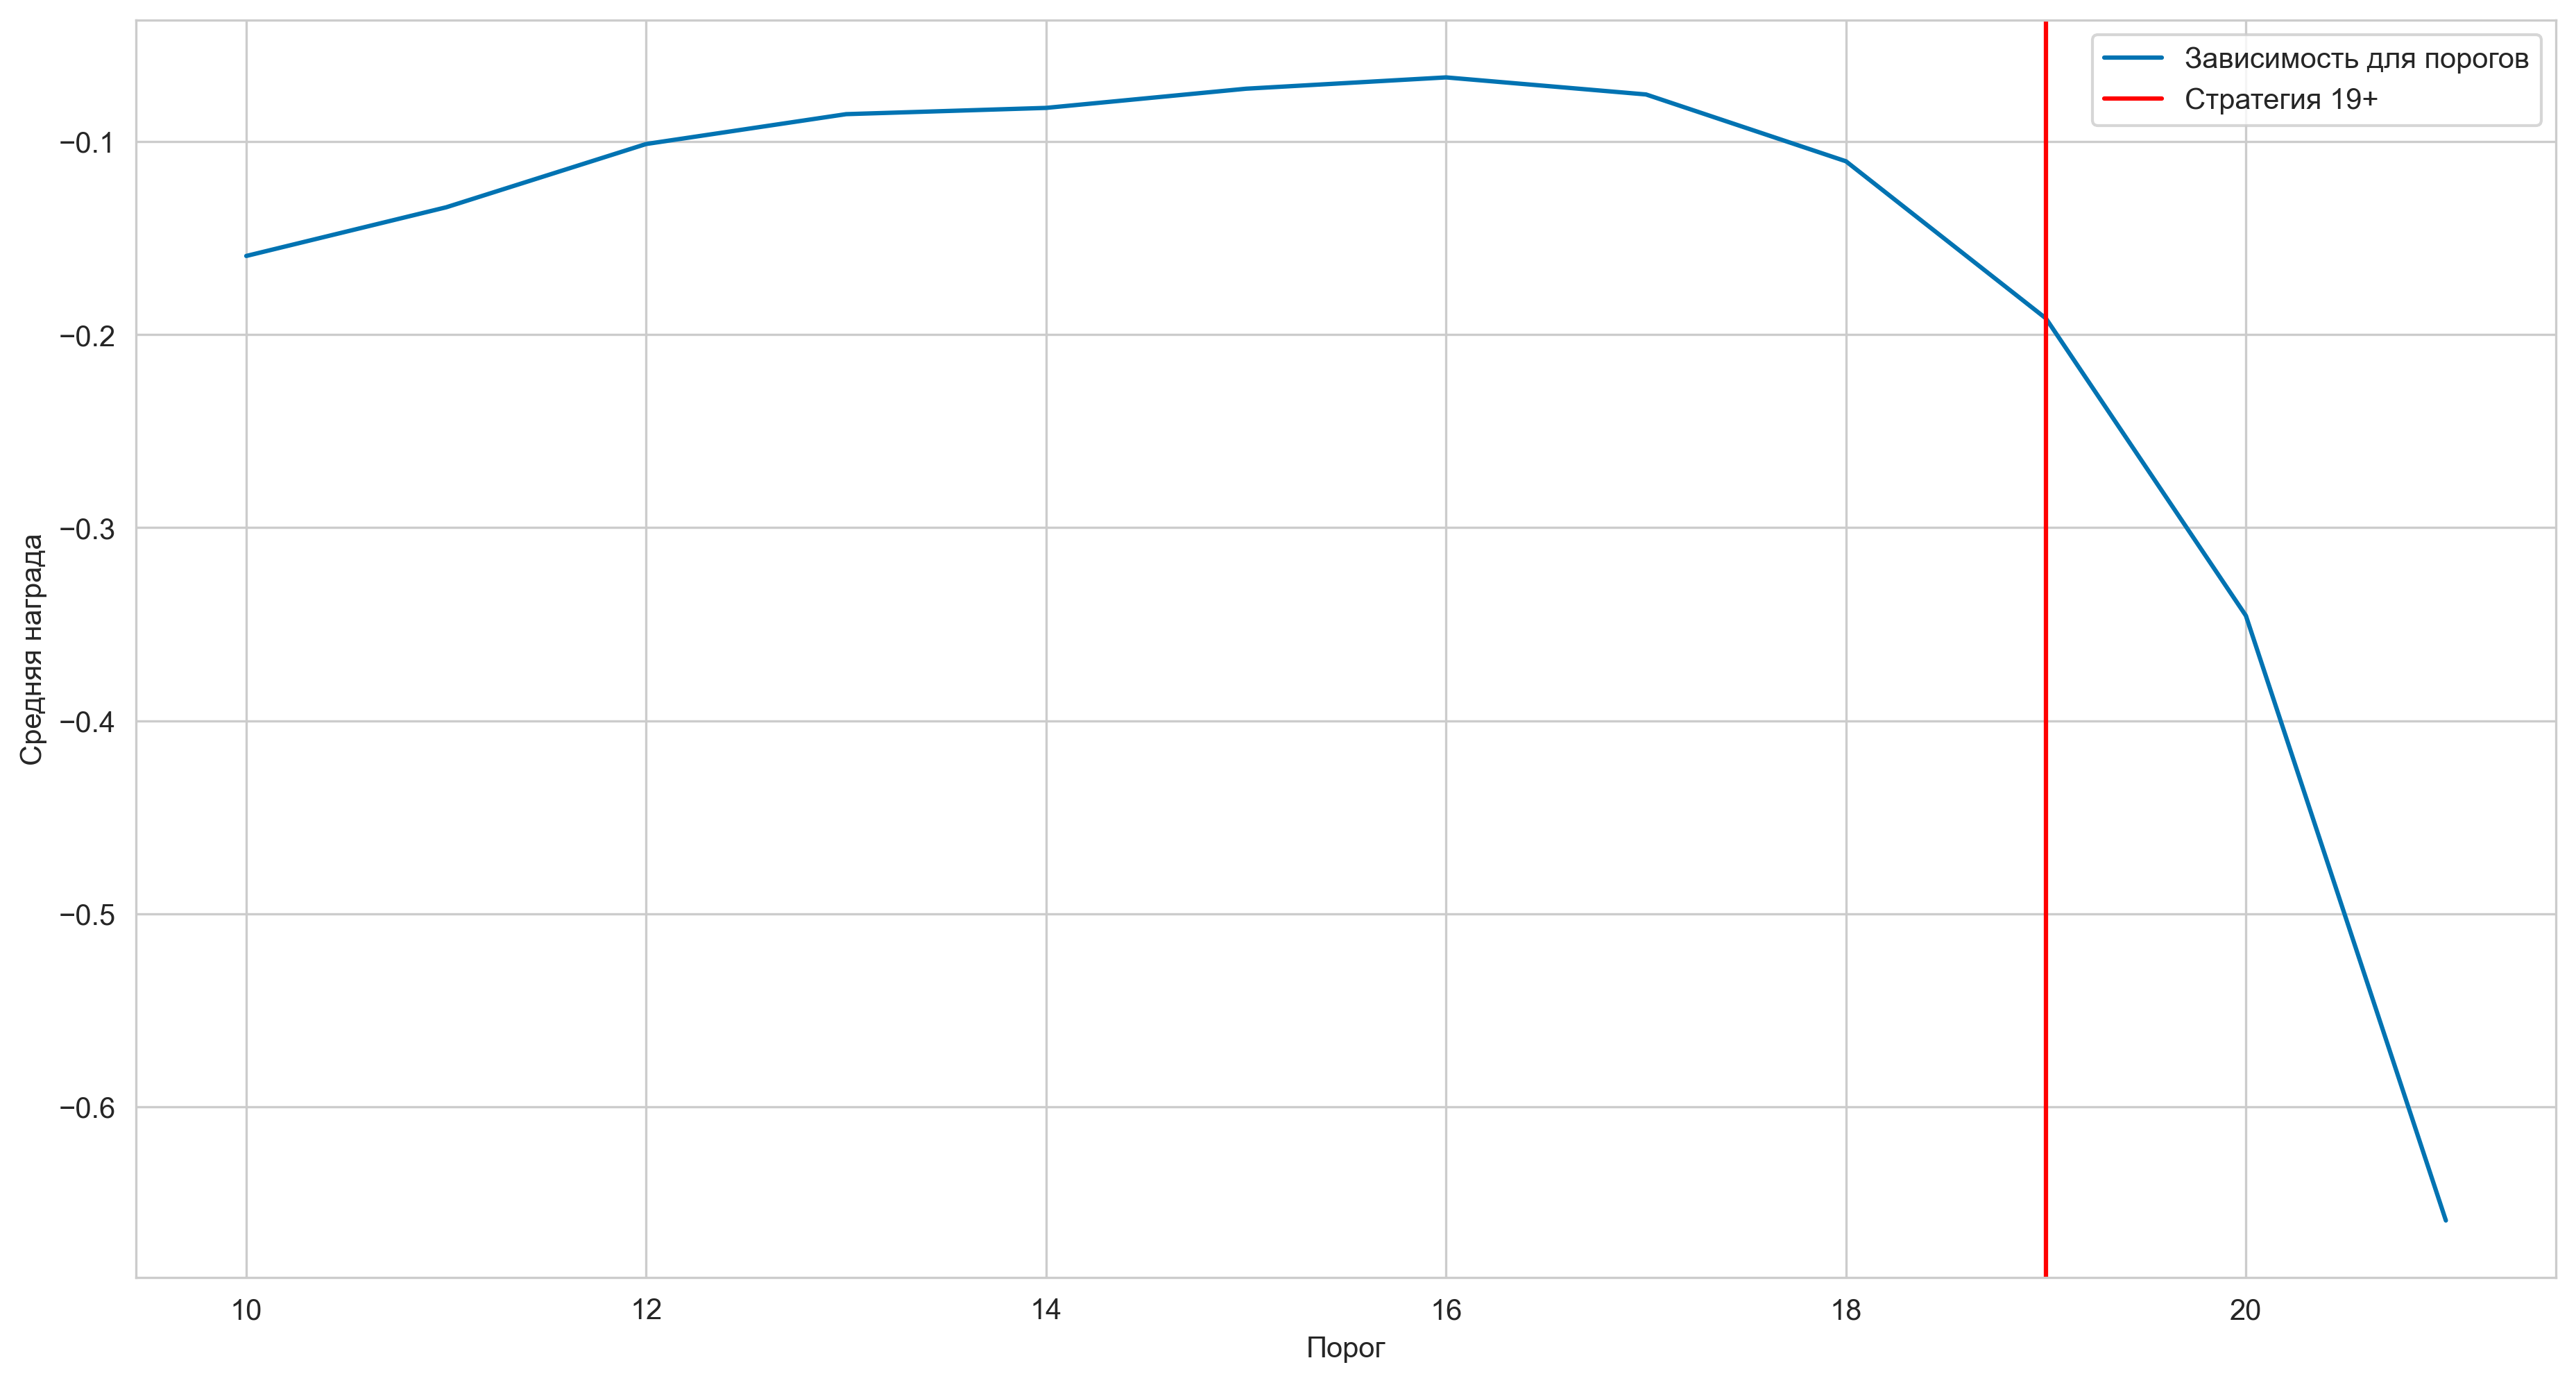

In [6]:
plt.figure(figsize=figsize)
plt.plot(x_range, mean_res, label="Зависимость для порогов")
plt.axvline(19, color="red", label="Стратегия 19+")
plt.xlabel("Порог")
plt.ylabel("Средняя награда")
plt.legend()
plt.show()

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.   

#### Monte-Carlo control с on-policy исследованием

##### Подготовительные функции

In [7]:
# constants
nA = 2
nS = 380

In [8]:
def collect_states(env, NUM_GAMES=10_000):
    states = set()
    for _ in range(NUM_GAMES):
        done = False
        observation = env.reset()
        states.add(observation)
        while not done:
            action = random.randint(0, nA - 1)
            observation, reward, done, _ = env.step(action)
            states.add(observation)
    return states

In [9]:
for _ in range(10):
    env = gym.make('Blackjack-v1', natural=True)
    states = collect_states(env)
    if len(states) == nS:
        break
len(states)

380

In [10]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

In [11]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size, eps=0.1):
        super().__init__(action_size)
        self.eps = eps
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)
        self.Q = np.zeros((states_size, action_size))

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q=None):
        Q = Q if Q is not None else self.Q
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    
    def get_Q_by_R(self, R, Q_default=None):
        Q = Q_default if Q_default is not None else self.Q
        for s in range(self.states_size):
            for a in range(self.action_size):
                if len(R[s][a]) > 0:
                    Q[s][a] = np.mean(R[s][a])
        self.Q = Q
        return Q

In [12]:
def run_episode_actions(env, agent, eps=0.5):
    observation = env.reset()
    next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
    states, actions, rewards = [observation], [next_action], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        states.append(observation)
        next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

def update_returns_actions(R, states, actions, rewards, gamma=1.0, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state_to_idx[state]] == -1:
            state_first_visit[state_to_idx[state]] = t
    g = 0
    if R_all is not None:
        _ = [R_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]
    if state_first_visit[state_to_idx[states[-1]]] == len(states)-1:
        R[state_to_idx[states[-1]]][actions[-1]].append(g)
        if R_all is not None:
            R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[state_to_idx[states[t]]] == t:
            R[state_to_idx[states[t]]][actions[t]].append(g)
            if R_all is not None:
                R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    return R, R_all

In [13]:
def plot_rewards(reward_list, period=1_000):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list)
    plt.xlabel("Сыграно обучающих сессий")
    plt.ylabel(f"Средняя награда за {period} игр")
    plt.show()

def plot_rewards_rolling(reward_list, period=1_000, roll=10):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list, color="cyan", label="Награда")
    plt.plot(x_range, pd.Series(reward_list).rolling(roll).mean(), color="blue", label=f"Скользящее ({roll}) среднее")
    plt.xlabel("Сыграно обучающих сессий")
    plt.ylabel(f"Средняя награда за {period} игр")
    plt.legend()
    plt.show()

##### Обучение

In [14]:
def mc_on_policy_train(env, agent, init_episodes=5_000, total_episodes=100_000, gamma=1,
                       eps=0.2, n_check=1_000, num_games=1_000):

    R, R_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ], [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = agent.Q
    pi = agent.pi

    for _ in range(init_episodes):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

    for n in tqdm.tqdm_notebook(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)
        Q = agent.get_Q_by_R(R, Q_default=agent.Q)
        pi = agent.update_pi(agent.Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games))
            reward_list.append(mean_reward)
            
    return agent, reward_list

<ipython-input-14-6905661f983f>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(range(total_episodes)):


  0%|          | 0/100000 [00:00<?, ?it/s]

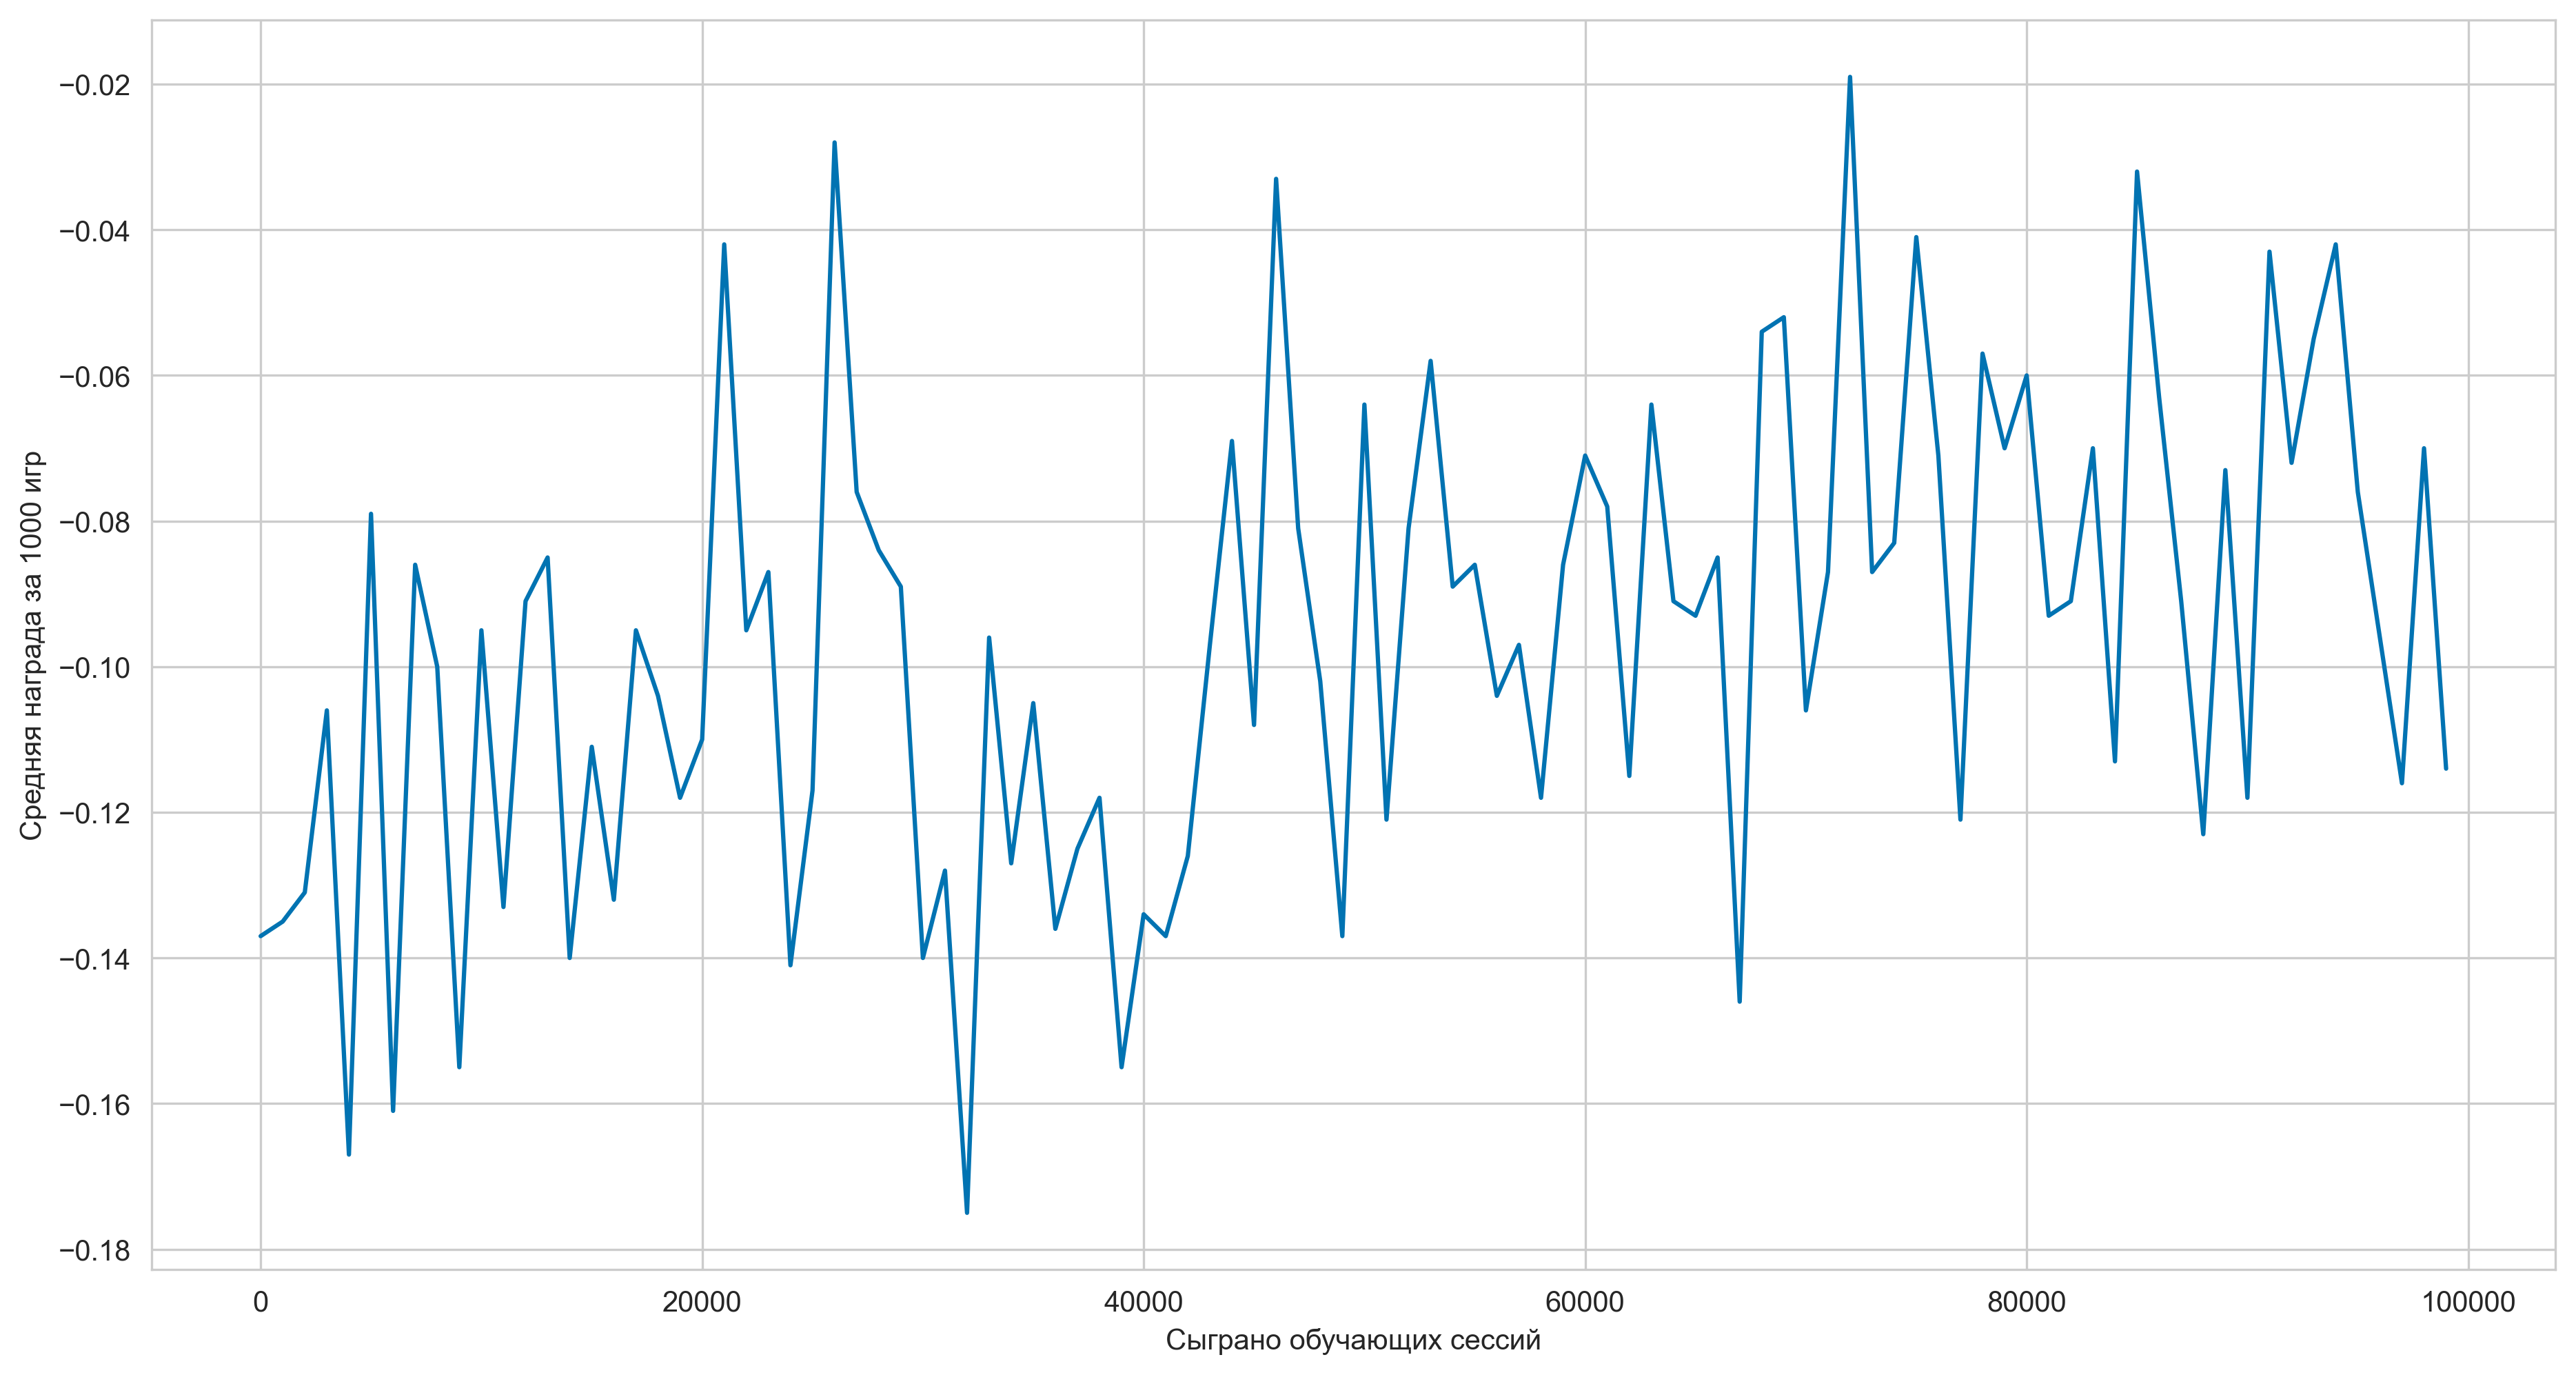

Финальная награда обученного агента равна -0.064 за 10000 игр


In [15]:
env = gym.make('Blackjack-v1', natural=True)
env._max_episode_steps = 10000
init_episodes, total_episodes = 10_000, 100_000
num_games=10_000
n_check = 1_000

gamma = 1
eps = 0.1

agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

agent, reward_list = mc_on_policy_train(env, agent, init_episodes, total_episodes, gamma, eps, n_check)

plot_rewards(reward_list, n_check)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

#### Monte Carlo control offpolicy

In [16]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [17]:
def update_lists(s, a, g, w, Q, C, Q_all):
    s = state_to_idx[s]
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    if Q_all is not None:
        Q_all[s][a][-1] = g


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0, Q_all=None):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA
    if Q_all is not None:
        _ = [Q_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C, Q_all)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[state_to_idx[states[t+1]]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C, Q_all)
    return Q, C, Q_all

In [18]:
def mc_off_policy_train(env, agent, total_episodes=100_000, gamma=1, eps=0.2, n_check=1_000, num_games=1_000):

    Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    C = np.zeros((nS, nA), dtype=float)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards,
                                                          epsilon=eps, gamma=gamma, Q_all=Q_all)
        pi = agent.update_pi(Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games, env=env))
            reward_list.append(mean_reward)
            
    return agent, reward_list

  0%|          | 0/100000 [00:00<?, ?it/s]

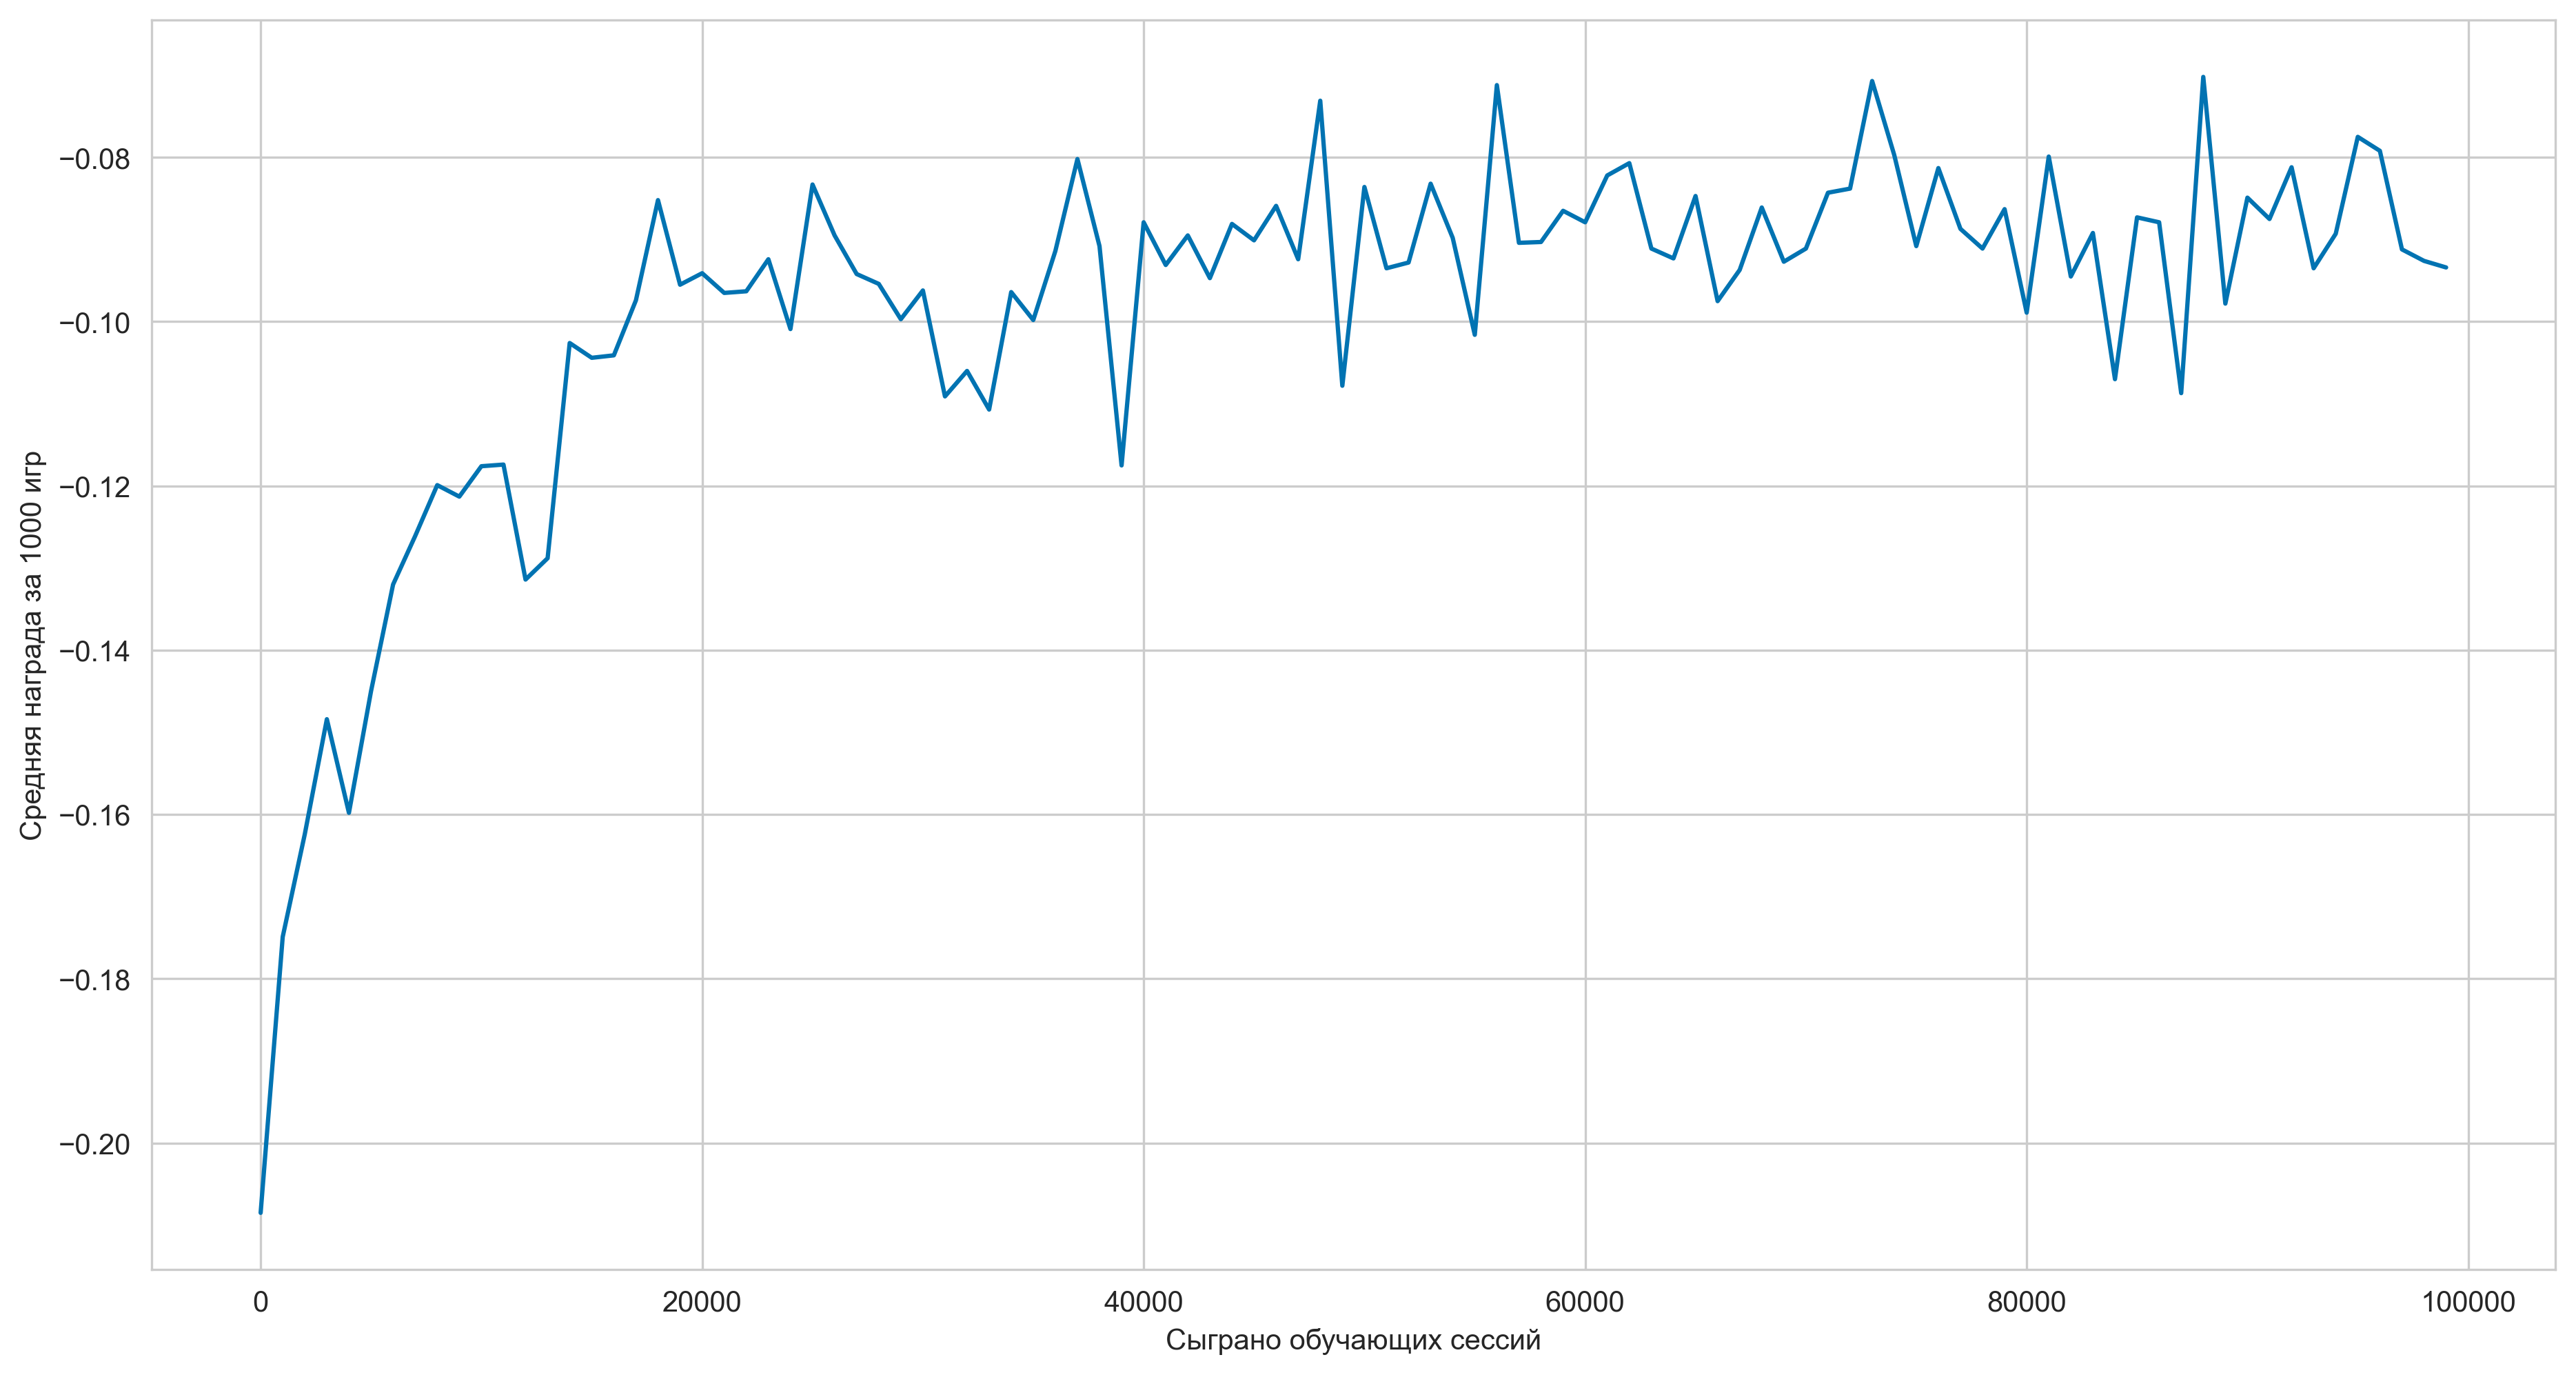

Финальная награда обученного агента равна -0.083 за 10000 игр


In [19]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

total_episodes = 100_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.2

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [20]:
def optuna_reward_mc(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = gym.make('Blackjack-v1', natural=True)

    # env._max_episode_steps = 10000
    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1
    eps = 0.2

    agent, _ = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)
    
#     Q = Q_learn(epsilon=epsilon, alpha=alpha, n_episods=100000, leave=False)
    return np.mean(sample_games(agent, num_games=games_check, env=env))

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_mc, n_trials=20)

[I 2021-10-24 23:09:05,209] A new study created in memory with name: no-name-a24bb325-4f7e-4d17-9ccc-774843b3a502


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:09:27,757] Trial 0 finished with value: -0.0727 and parameters: {'eps': 0.748306029050991}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:09:50,281] Trial 1 finished with value: -0.0965 and parameters: {'eps': 0.18916204744741427}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:10:12,859] Trial 2 finished with value: -0.0875 and parameters: {'eps': 0.7251991287540126}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:10:35,400] Trial 3 finished with value: -0.0859 and parameters: {'eps': 0.47683284216118693}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:10:57,865] Trial 4 finished with value: -0.0797 and parameters: {'eps': 0.8080774717889345}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:11:20,343] Trial 5 finished with value: -0.0969 and parameters: {'eps': 0.909738832632055}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:11:42,989] Trial 6 finished with value: -0.078 and parameters: {'eps': 0.3756639324588248}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:12:05,613] Trial 7 finished with value: -0.1008 and parameters: {'eps': 0.22956066562719224}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:12:28,179] Trial 8 finished with value: -0.0728 and parameters: {'eps': 0.730014164029497}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:12:50,947] Trial 9 finished with value: -0.0854 and parameters: {'eps': 0.9655217826348645}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:13:14,449] Trial 10 finished with value: -0.0985 and parameters: {'eps': 0.029398885462881497}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:13:37,304] Trial 11 finished with value: -0.0771 and parameters: {'eps': 0.6541986099114634}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:14:00,288] Trial 12 finished with value: -0.0745 and parameters: {'eps': 0.6086816368967499}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:14:25,134] Trial 13 finished with value: -0.0998 and parameters: {'eps': 0.8149453825149566}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:14:47,932] Trial 14 finished with value: -0.0796 and parameters: {'eps': 0.5127535350241247}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:15:10,826] Trial 15 finished with value: -0.0752 and parameters: {'eps': 0.7765962358096401}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:15:33,598] Trial 16 finished with value: -0.0994 and parameters: {'eps': 0.5931387992005859}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:15:56,346] Trial 17 finished with value: -0.0887 and parameters: {'eps': 0.884660396470877}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:16:19,293] Trial 18 finished with value: -0.1026 and parameters: {'eps': 0.703590642334528}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:16:42,267] Trial 19 finished with value: -0.0839 and parameters: {'eps': 0.40012856558630794}. Best is trial 0 with value: -0.0727.


  0%|          | 0/100000 [00:00<?, ?it/s]

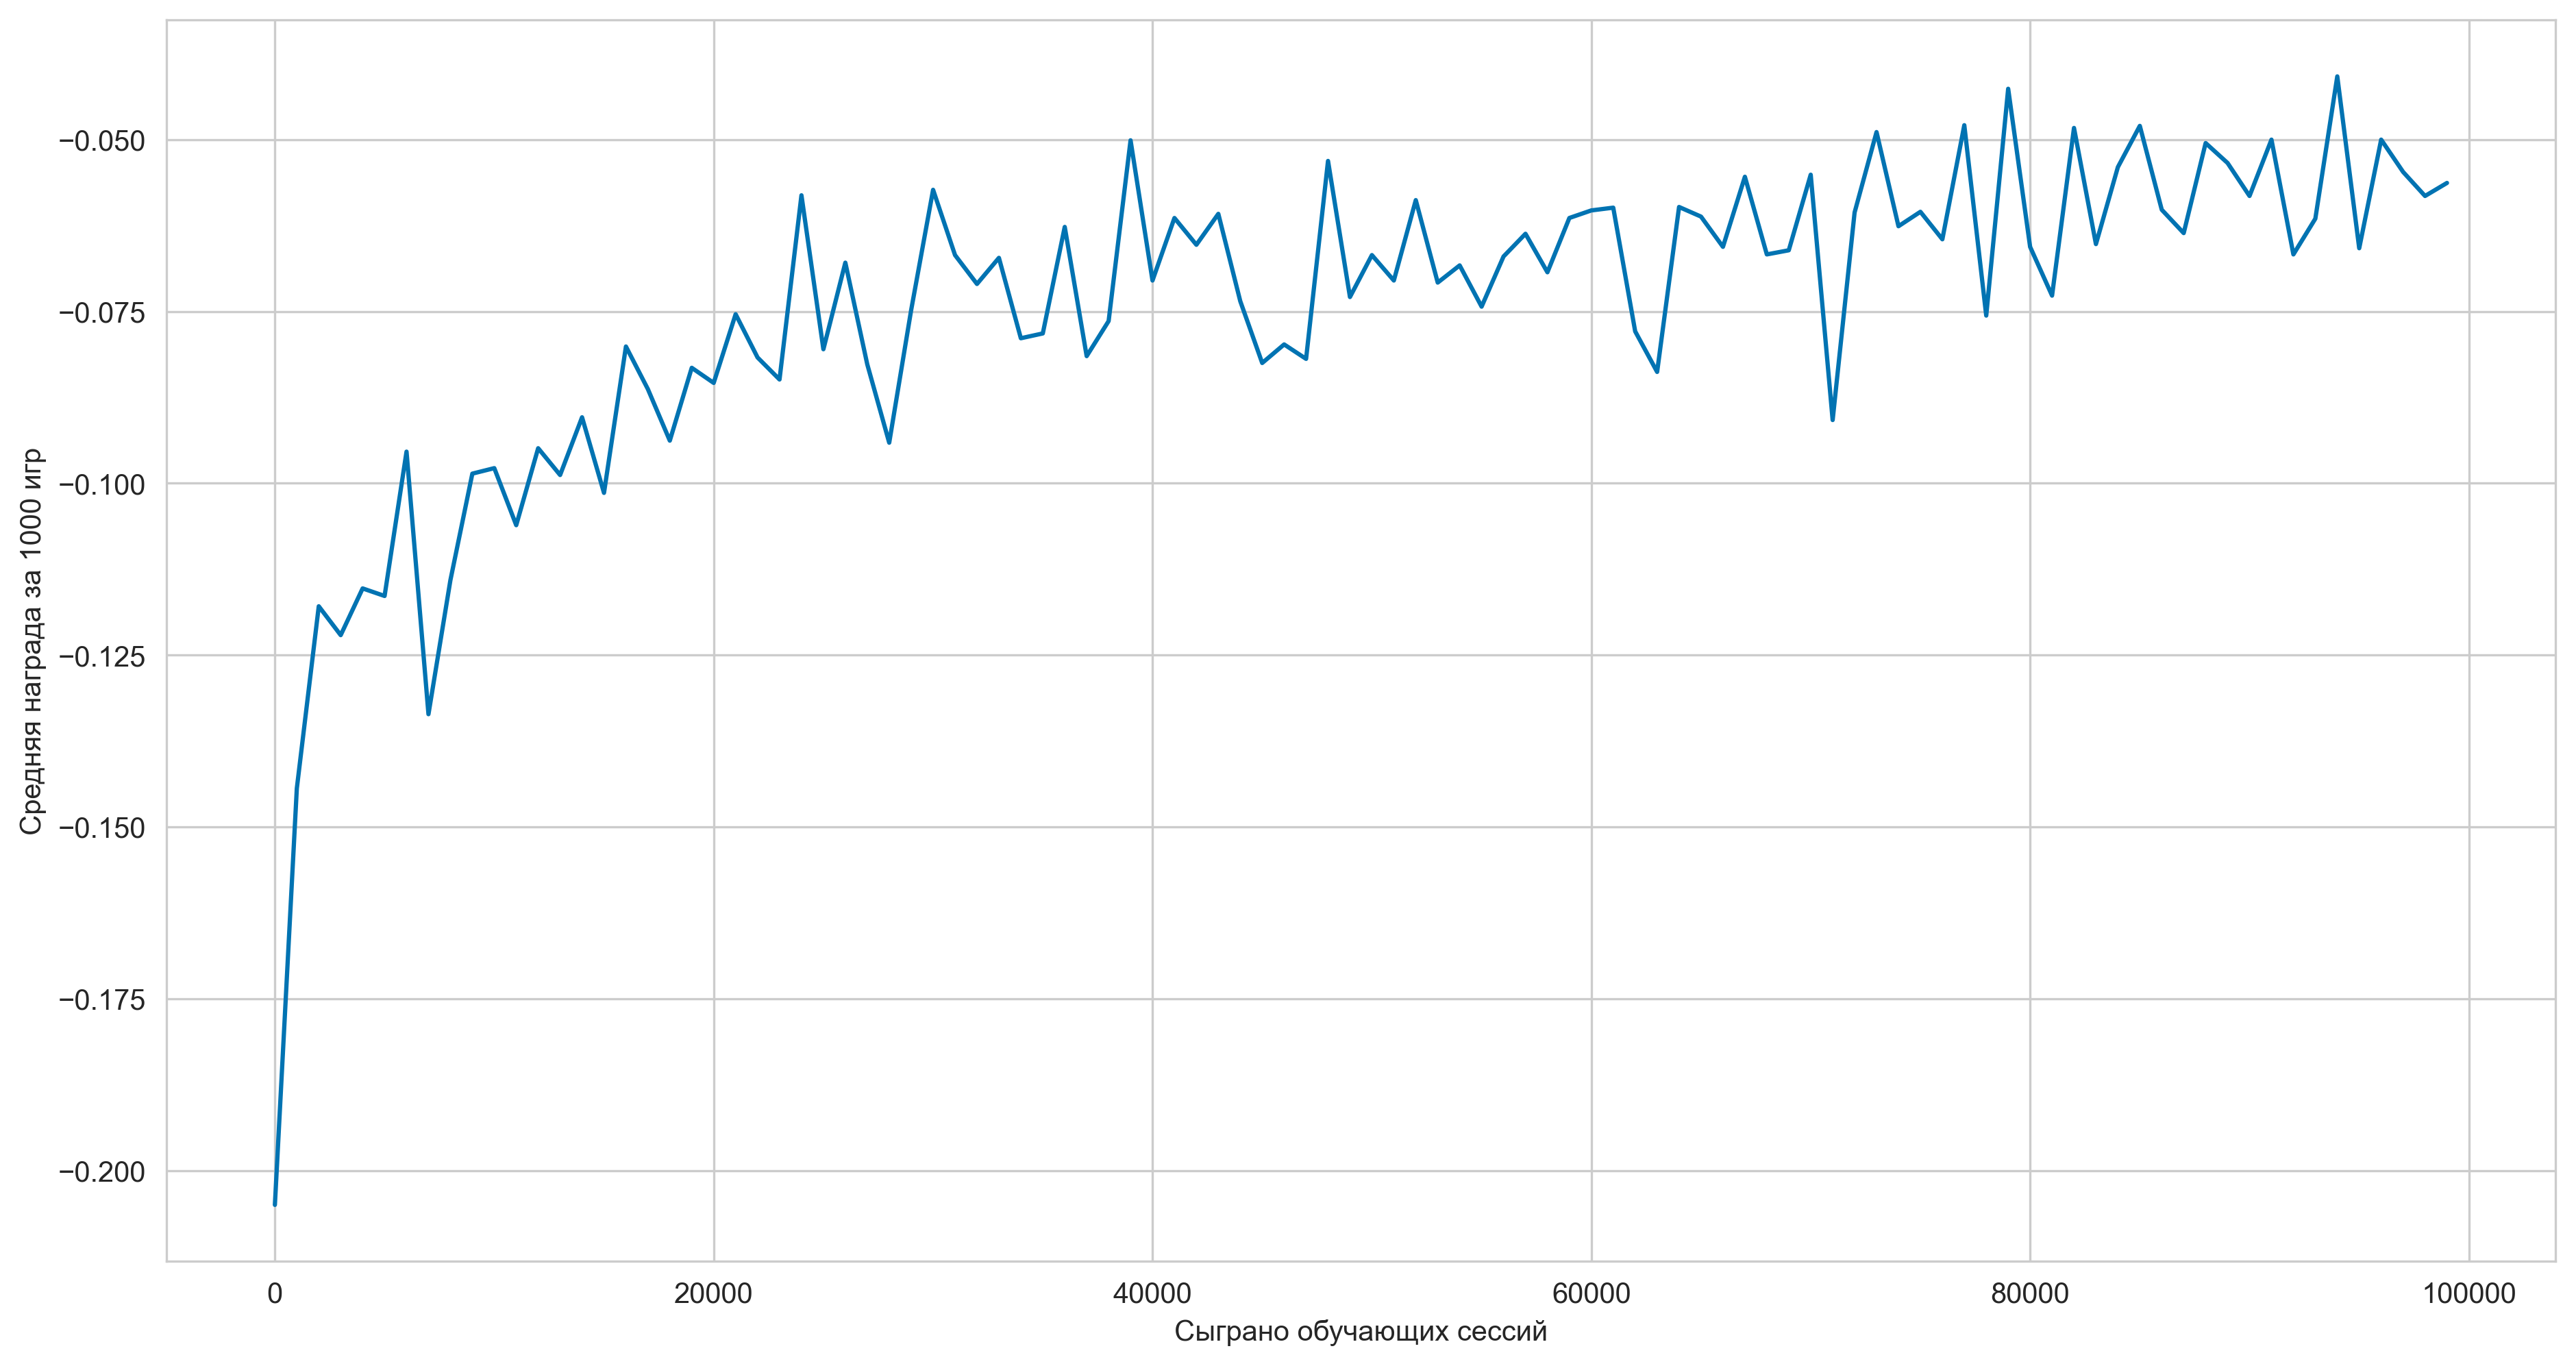

Финальная награда обученного агента равна -0.053 за 10000 игр


In [22]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.2

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma,
                                         study.best_params["eps"], period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

#### Q-Learning

In [23]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(0, action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [24]:
def Q_learning_episode(env, agent, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    observation = env.reset()
    s = state_to_idx[observation]
    a = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = state_to_idx[observation]
        a_prime = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
#         s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
    return reward

In [25]:
def Q_learning_train(env, agent, total_episodes=1_000_000, gamma=1, eps=0.2, alpha=0.1,
                     n_check=1000, num_games=1_000):

#     Q_hist_Qlearn = [ ]
    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        reward = Q_learning_episode(env, agent, Q, alpha=alpha, epsilon=eps, gamma=gamma)
        pi = agent.update_pi(Q)
#         Q_hist_Qlearn.append(np.copy(Q))
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games, env=env))
            reward_list.append(mean_reward)
    
    return agent, reward_list

  0%|          | 0/200000 [00:00<?, ?it/s]

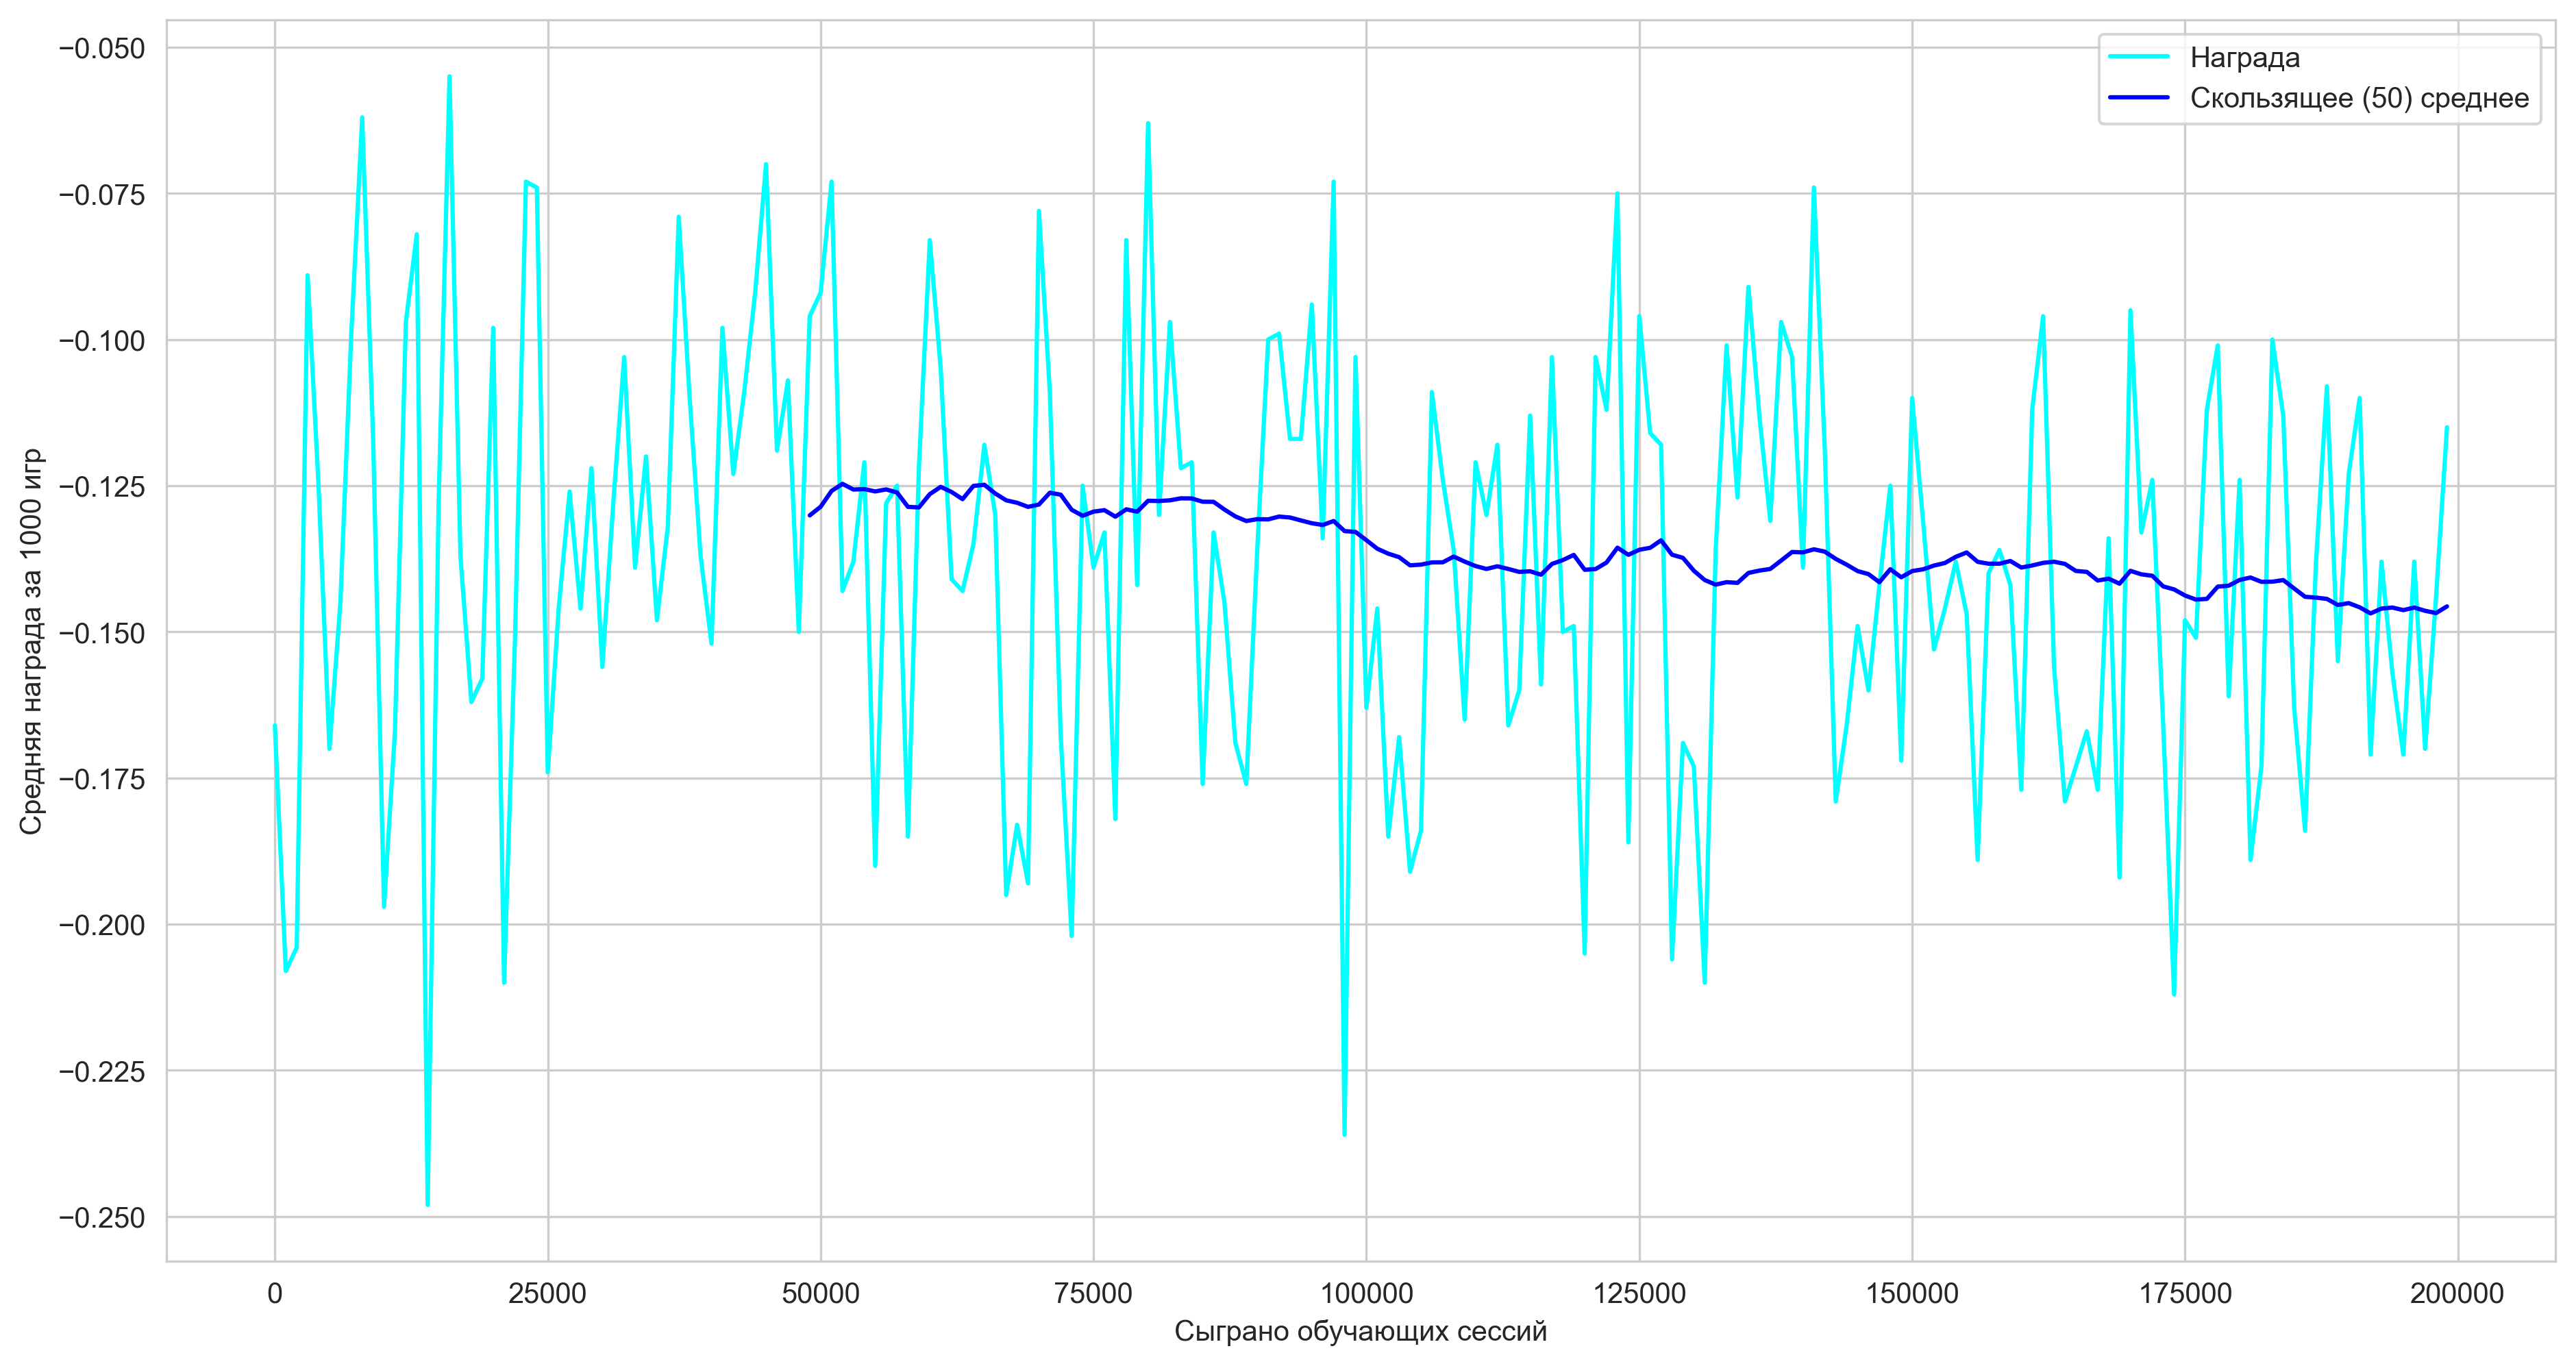

Финальная награда обученного агента равна -0.110 за 10000 игр


In [26]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = 0.2
alpha = 0.1

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [27]:
def optuna_reward_Q_learning(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    alpha = trial.suggest_uniform("alpha", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = gym.make('Blackjack-v1', natural=True)

    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1

    agent, _ = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=period)
    
    res = np.mean(sample_games(agent, num_games=games_check, env=env))
    env.close()
    return res

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_Q_learning, n_trials=100)

[I 2021-10-24 23:18:44,353] A new study created in memory with name: no-name-fe7dc866-c14b-49d8-a438-dc46e3c3c496


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:18:54,023] Trial 0 finished with value: -0.1824 and parameters: {'eps': 0.3460313217448986, 'alpha': 0.985736740722284}. Best is trial 0 with value: -0.1824.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:03,949] Trial 1 finished with value: -0.1262 and parameters: {'eps': 0.1514080810516485, 'alpha': 0.12089228939831442}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:13,217] Trial 2 finished with value: -0.1956 and parameters: {'eps': 0.5128629900327336, 'alpha': 0.5488173877232415}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:22,381] Trial 3 finished with value: -0.1847 and parameters: {'eps': 0.3816369041668445, 'alpha': 0.6573472628309195}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:31,578] Trial 4 finished with value: -0.1507 and parameters: {'eps': 0.4877596831610388, 'alpha': 0.6445998801624575}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:41,303] Trial 5 finished with value: -0.1453 and parameters: {'eps': 0.8050588050646754, 'alpha': 0.027215787468358288}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:19:50,693] Trial 6 finished with value: -0.1587 and parameters: {'eps': 0.7508990045282194, 'alpha': 0.48797757535209363}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:00,054] Trial 7 finished with value: -0.1697 and parameters: {'eps': 0.8496548834773698, 'alpha': 0.7350422001994984}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:09,355] Trial 8 finished with value: -0.1682 and parameters: {'eps': 0.6634747991672568, 'alpha': 0.6170743386425721}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:19,078] Trial 9 finished with value: -0.1324 and parameters: {'eps': 0.2564294020304987, 'alpha': 0.1405634280635908}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:29,116] Trial 10 finished with value: -0.1449 and parameters: {'eps': 0.01473985989453036, 'alpha': 0.22769299742770707}. Best is trial 1 with value: -0.1262.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:38,886] Trial 11 finished with value: -0.1133 and parameters: {'eps': 0.08009172279141213, 'alpha': 0.18059101488602114}. Best is trial 11 with value: -0.1133.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:48,915] Trial 12 finished with value: -0.1052 and parameters: {'eps': 0.01156275856149723, 'alpha': 0.3243326635382251}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:20:58,872] Trial 13 finished with value: -0.1429 and parameters: {'eps': 0.012198032929874474, 'alpha': 0.3227598654575967}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:08,179] Trial 14 finished with value: -0.1575 and parameters: {'eps': 0.15525294289500097, 'alpha': 0.3527109774466695}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:17,492] Trial 15 finished with value: -0.1391 and parameters: {'eps': 0.11188473953589488, 'alpha': 0.4164536215880028}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:26,995] Trial 16 finished with value: -0.1494 and parameters: {'eps': 0.9560173509844279, 'alpha': 0.24784528753706975}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:37,144] Trial 17 finished with value: -0.1934 and parameters: {'eps': 0.2262189943810632, 'alpha': 0.021584956417616485}. Best is trial 12 with value: -0.1052.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:47,335] Trial 18 finished with value: -0.1008 and parameters: {'eps': 0.0071907554937583485, 'alpha': 0.23856836332772677}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:21:56,453] Trial 19 finished with value: -0.1598 and parameters: {'eps': 0.24909500678694502, 'alpha': 0.8192953945336793}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:05,740] Trial 20 finished with value: -0.1581 and parameters: {'eps': 0.520122042338241, 'alpha': 0.42814863079839577}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:15,953] Trial 21 finished with value: -0.106 and parameters: {'eps': 0.0032340893191812603, 'alpha': 0.23727687986502796}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:25,899] Trial 22 finished with value: -0.1302 and parameters: {'eps': 0.011116028293894284, 'alpha': 0.3222205433558077}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:35,513] Trial 23 finished with value: -0.1434 and parameters: {'eps': 0.09768877450147222, 'alpha': 0.24949510028609256}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:45,495] Trial 24 finished with value: -0.1424 and parameters: {'eps': 0.20169414776900169, 'alpha': 0.07655158445809182}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:22:54,840] Trial 25 finished with value: -0.1462 and parameters: {'eps': 0.3713592793131383, 'alpha': 0.4008357919633483}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:04,364] Trial 26 finished with value: -0.1511 and parameters: {'eps': 0.08066156882627717, 'alpha': 0.2807847159371768}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:13,948] Trial 27 finished with value: -0.1363 and parameters: {'eps': 0.30917267045421964, 'alpha': 0.18036532346574063}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:23,797] Trial 28 finished with value: -0.1472 and parameters: {'eps': 0.00808385621563007, 'alpha': 0.46938071062004894}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:33,139] Trial 29 finished with value: -0.1639 and parameters: {'eps': 0.4405251704714748, 'alpha': 0.3456122365675579}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:42,494] Trial 30 finished with value: -0.1289 and parameters: {'eps': 0.6401406007711578, 'alpha': 0.9624716802408496}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:23:52,364] Trial 31 finished with value: -0.1549 and parameters: {'eps': 0.08796724102605366, 'alpha': 0.13999789918608113}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:01,986] Trial 32 finished with value: -0.1539 and parameters: {'eps': 0.15902858048443946, 'alpha': 0.17628648602305388}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:12,017] Trial 33 finished with value: -0.1251 and parameters: {'eps': 0.0719609115529, 'alpha': 0.0917295789570817}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:21,596] Trial 34 finished with value: -0.1656 and parameters: {'eps': 0.18596096594794287, 'alpha': 0.20637662377448407}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:31,253] Trial 35 finished with value: -0.1533 and parameters: {'eps': 0.061372958692757315, 'alpha': 0.3024759040078334}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:41,086] Trial 36 finished with value: -0.1251 and parameters: {'eps': 0.2912229468916021, 'alpha': 0.08608301965433982}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:24:50,449] Trial 37 finished with value: -0.1592 and parameters: {'eps': 0.13535449243078534, 'alpha': 0.37455648883370846}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:00,113] Trial 38 finished with value: -0.1464 and parameters: {'eps': 0.05282166942349481, 'alpha': 0.28158711487705945}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:09,203] Trial 39 finished with value: -0.1656 and parameters: {'eps': 0.1393880246254909, 'alpha': 0.5741508649235539}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:19,155] Trial 40 finished with value: -0.1144 and parameters: {'eps': 0.03624790945272871, 'alpha': 0.20015577857257186}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:29,430] Trial 41 finished with value: -0.1645 and parameters: {'eps': 0.002043848872387206, 'alpha': 0.16990845733081966}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:39,167] Trial 42 finished with value: -0.1385 and parameters: {'eps': 0.051141039202284924, 'alpha': 0.23736363728984}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:49,116] Trial 43 finished with value: -0.1179 and parameters: {'eps': 0.1120109104710248, 'alpha': 0.11778207782930239}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:25:59,225] Trial 44 finished with value: -0.185 and parameters: {'eps': 0.17196415219027245, 'alpha': 0.005952059880794031}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:08,581] Trial 45 finished with value: -0.1398 and parameters: {'eps': 0.0463574356241993, 'alpha': 0.5282384385701206}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:18,264] Trial 46 finished with value: -0.151 and parameters: {'eps': 0.11825339788280863, 'alpha': 0.21099102692080635}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:27,731] Trial 47 finished with value: -0.1769 and parameters: {'eps': 0.212257147871041, 'alpha': 0.2572439930866457}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:37,060] Trial 48 finished with value: -0.1739 and parameters: {'eps': 0.583094065360289, 'alpha': 0.46451106342427634}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:47,346] Trial 49 finished with value: -0.1077 and parameters: {'eps': 0.03445059432863762, 'alpha': 0.07190984749249166}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:26:57,422] Trial 50 finished with value: -0.106 and parameters: {'eps': 0.26939258087254697, 'alpha': 0.052216231550075654}. Best is trial 18 with value: -0.1008.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:07,328] Trial 51 finished with value: -0.0979 and parameters: {'eps': 0.27885686571468227, 'alpha': 0.06503555343652595}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:17,260] Trial 52 finished with value: -0.1507 and parameters: {'eps': 0.4223291966188101, 'alpha': 0.06277324187721234}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:27,211] Trial 53 finished with value: -0.1558 and parameters: {'eps': 0.3269948637618017, 'alpha': 0.03899133080086287}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:36,991] Trial 54 finished with value: -0.1408 and parameters: {'eps': 0.27417550424348264, 'alpha': 0.13306527224674608}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:46,828] Trial 55 finished with value: -0.1341 and parameters: {'eps': 0.5076091802758679, 'alpha': 0.054055437179275585}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:27:56,486] Trial 56 finished with value: -0.117 and parameters: {'eps': 0.7478491789939553, 'alpha': 0.10306392656603655}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:06,118] Trial 57 finished with value: -0.1489 and parameters: {'eps': 0.3847932149869397, 'alpha': 0.14912969572958878}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:16,272] Trial 58 finished with value: -0.1623 and parameters: {'eps': 0.24452361626912103, 'alpha': 0.009749504825268207}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:26,254] Trial 59 finished with value: -0.1099 and parameters: {'eps': 0.45334659855247394, 'alpha': 0.035457904085489295}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:35,528] Trial 60 finished with value: -0.1772 and parameters: {'eps': 0.028088931677256547, 'alpha': 0.7498068608775215}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:45,514] Trial 61 finished with value: -0.1471 and parameters: {'eps': 0.4297270946045215, 'alpha': 0.03901454407409622}. Best is trial 51 with value: -0.0979.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:28:55,326] Trial 62 finished with value: -0.0858 and parameters: {'eps': 0.47652171266930743, 'alpha': 0.0014845268449384524}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:05,123] Trial 63 finished with value: -0.1441 and parameters: {'eps': 0.6154488197169282, 'alpha': 0.07261986502754922}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:14,814] Trial 64 finished with value: -0.1328 and parameters: {'eps': 0.5615834562604597, 'alpha': 0.11282307189293106}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:24,549] Trial 65 finished with value: -0.1512 and parameters: {'eps': 0.7044379712361263, 'alpha': 0.004829210030567119}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:34,397] Trial 66 finished with value: -0.1399 and parameters: {'eps': 0.08920316201453671, 'alpha': 0.1582418413785976}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:44,548] Trial 67 finished with value: -0.1057 and parameters: {'eps': 0.005339574729706088, 'alpha': 0.3657379045177579}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:29:53,899] Trial 68 finished with value: -0.1581 and parameters: {'eps': 0.3543935725418654, 'alpha': 0.3681772022671786}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:03,392] Trial 69 finished with value: -0.1612 and parameters: {'eps': 0.8970548840390855, 'alpha': 0.29810396101099035}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:12,708] Trial 70 finished with value: -0.1715 and parameters: {'eps': 0.4694668005334279, 'alpha': 0.4435618112115759}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:22,611] Trial 71 finished with value: -0.148 and parameters: {'eps': 0.024280749272235343, 'alpha': 0.2584204533567913}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:32,123] Trial 72 finished with value: -0.1507 and parameters: {'eps': 0.06904460844304945, 'alpha': 0.3259137543047926}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:42,418] Trial 73 finished with value: -0.1667 and parameters: {'eps': 0.004773530355178654, 'alpha': 0.10075334858298646}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:30:52,235] Trial 74 finished with value: -0.1071 and parameters: {'eps': 0.13496239230139137, 'alpha': 0.1911755049581194}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:01,839] Trial 75 finished with value: -0.1144 and parameters: {'eps': 0.11837660998159491, 'alpha': 0.21291704895030067}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:11,133] Trial 76 finished with value: -0.1633 and parameters: {'eps': 0.19363460638173552, 'alpha': 0.39163872786927934}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:20,614] Trial 77 finished with value: -0.1446 and parameters: {'eps': 0.14600030538086523, 'alpha': 0.27541343054150613}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:29,931] Trial 78 finished with value: -0.1555 and parameters: {'eps': 0.1704595985457191, 'alpha': 0.348507174419211}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:39,542] Trial 79 finished with value: -0.1319 and parameters: {'eps': 0.24367473959956393, 'alpha': 0.18092467909483273}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:49,072] Trial 80 finished with value: -0.1485 and parameters: {'eps': 0.08202563278948082, 'alpha': 0.3079706416274331}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:31:59,274] Trial 81 finished with value: -0.1436 and parameters: {'eps': 0.036005574212872225, 'alpha': 0.06418556968422356}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:09,046] Trial 82 finished with value: -0.1559 and parameters: {'eps': 0.05704835221398874, 'alpha': 0.22825976659045946}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:19,393] Trial 83 finished with value: -0.1761 and parameters: {'eps': 0.0004577956745466724, 'alpha': 0.13863880135780826}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:29,180] Trial 84 finished with value: -0.1284 and parameters: {'eps': 0.10056145599845286, 'alpha': 0.18595714791654194}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:39,022] Trial 85 finished with value: -0.1277 and parameters: {'eps': 0.12934545198684927, 'alpha': 0.12096599184232995}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:49,315] Trial 86 finished with value: -0.103 and parameters: {'eps': 0.03616898462371868, 'alpha': 0.08271008393935741}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:32:58,545] Trial 87 finished with value: -0.1685 and parameters: {'eps': 0.3895917004942052, 'alpha': 0.9986433927503319}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:08,374] Trial 88 finished with value: -0.1384 and parameters: {'eps': 0.30376447586865113, 'alpha': 0.08910410644572098}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:17,987] Trial 89 finished with value: -0.1443 and parameters: {'eps': 0.054945328657737644, 'alpha': 0.3301885592783312}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:28,248] Trial 90 finished with value: -0.1469 and parameters: {'eps': 0.0232371899373007, 'alpha': 0.04149743183051216}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:38,286] Trial 91 finished with value: -0.1045 and parameters: {'eps': 0.028514800734754313, 'alpha': 0.16030293094422216}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:48,195] Trial 92 finished with value: -0.1265 and parameters: {'eps': 0.07715437092414498, 'alpha': 0.15174908905240175}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:33:57,822] Trial 93 finished with value: -0.1513 and parameters: {'eps': 0.10371358239818931, 'alpha': 0.23365865709887543}. Best is trial 62 with value: -0.0858.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:07,748] Trial 94 finished with value: -0.0851 and parameters: {'eps': 0.04476942275397597, 'alpha': 0.20167993533683098}. Best is trial 94 with value: -0.0851.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:17,576] Trial 95 finished with value: -0.1413 and parameters: {'eps': 0.036190460213244985, 'alpha': 0.26754718069475114}. Best is trial 94 with value: -0.0851.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:27,205] Trial 96 finished with value: -0.1223 and parameters: {'eps': 0.5334836534061627, 'alpha': 0.16487914747130342}. Best is trial 94 with value: -0.0851.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:37,263] Trial 97 finished with value: -0.119 and parameters: {'eps': 0.01853113665262354, 'alpha': 0.21387703334966388}. Best is trial 94 with value: -0.0851.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:47,531] Trial 98 finished with value: -0.1518 and parameters: {'eps': 0.0005718913456429974, 'alpha': 0.9174097021992959}. Best is trial 94 with value: -0.0851.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-24 23:34:57,800] Trial 99 finished with value: -0.1251 and parameters: {'eps': 0.060973762386608, 'alpha': 0.026253308100028228}. Best is trial 94 with value: -0.0851.


  0%|          | 0/200000 [00:00<?, ?it/s]

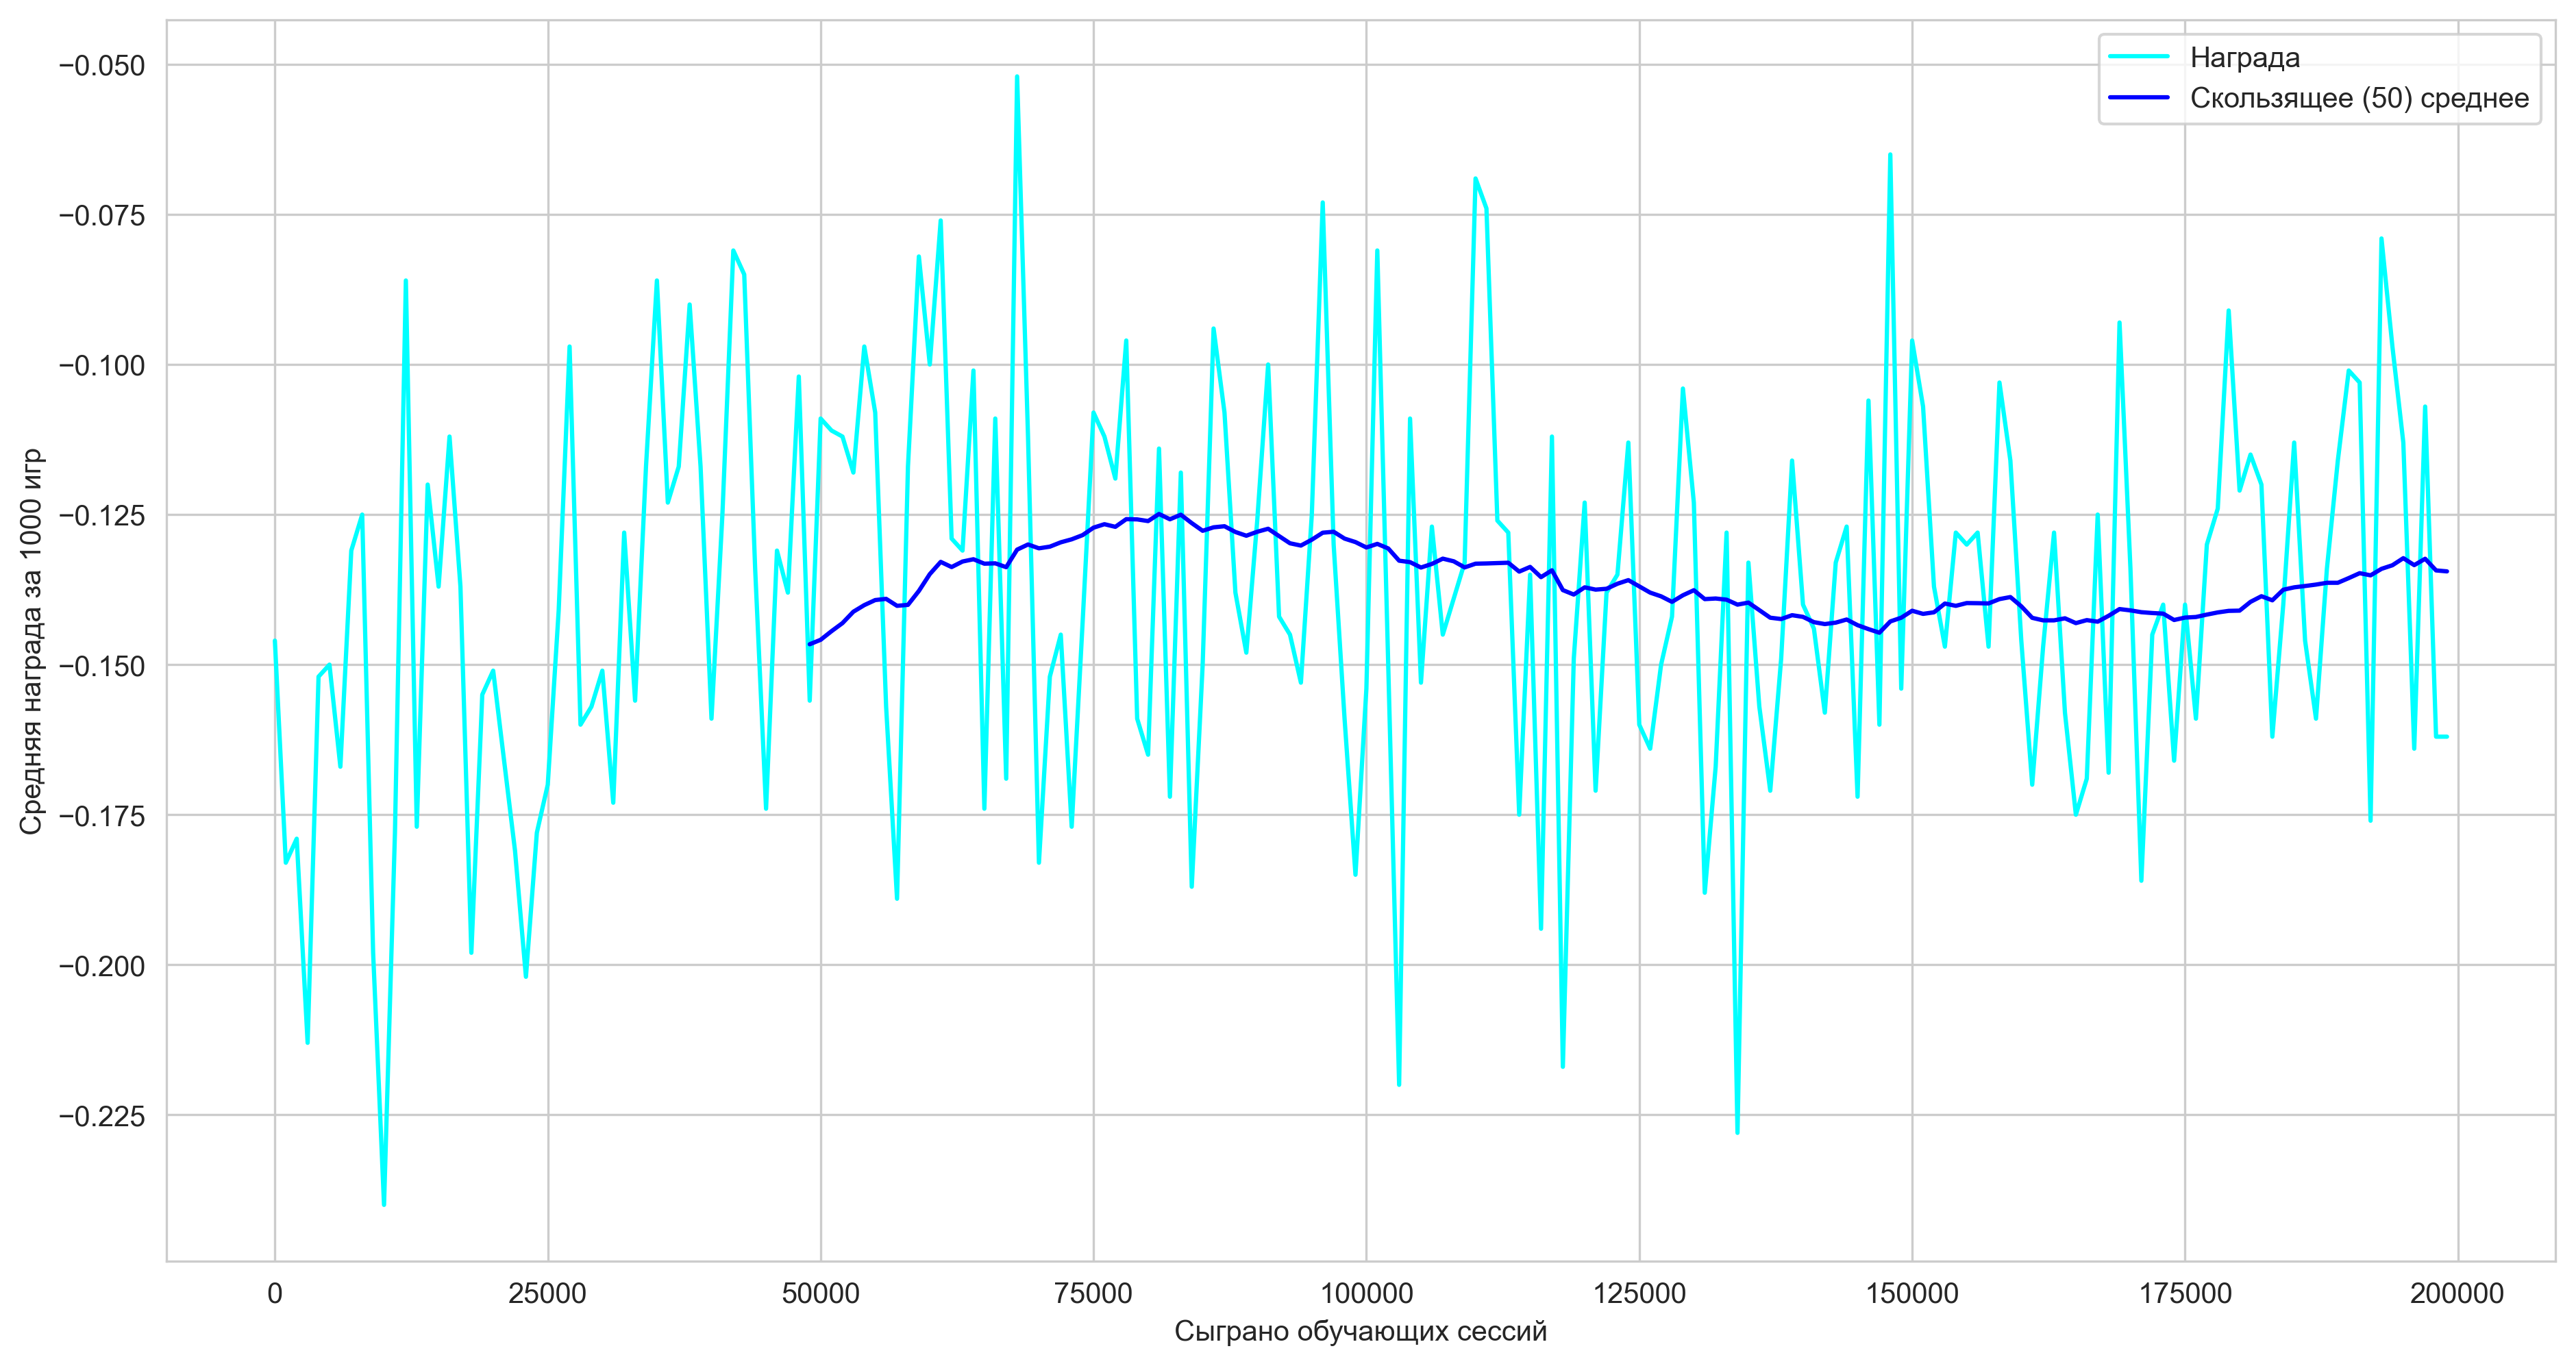

Финальная награда обученного агента равна -0.134 за 10000 игр


In [30]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

total_episodes = 200_000
gamma = 1
eps = study.best_params["eps"]
alpha = study.best_params["alpha"]

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha,
                                      n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится.
Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными,
а на самом деле у игрока есть ещё и другие возможности. Реализовывать __split__ может оказаться непросто,
поэтому давайте ограничимся удвоением ставки.  
Итак, у игрока появляется дополнительное действие:  
- __double__ — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [31]:
from BlackJackDouble import BlackjackDoubleEnv
env = BlackjackDoubleEnv(natural=True, double=True)

In [32]:
# Пример работы окружения
print(env.reset())
print(env.step(2))

(14, 10, False)
((18, 10, False), -2.0, True, {})


### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [33]:
# constants
nA = 3
nS = 380

In [34]:
for _ in range(10):
    env = BlackjackDoubleEnv(natural=True, double=True)
    states = collect_states(env, NUM_GAMES=30_000)
    if len(states) == nS:
        break
len(states)

380

In [35]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

  0%|          | 0/200000 [00:00<?, ?it/s]

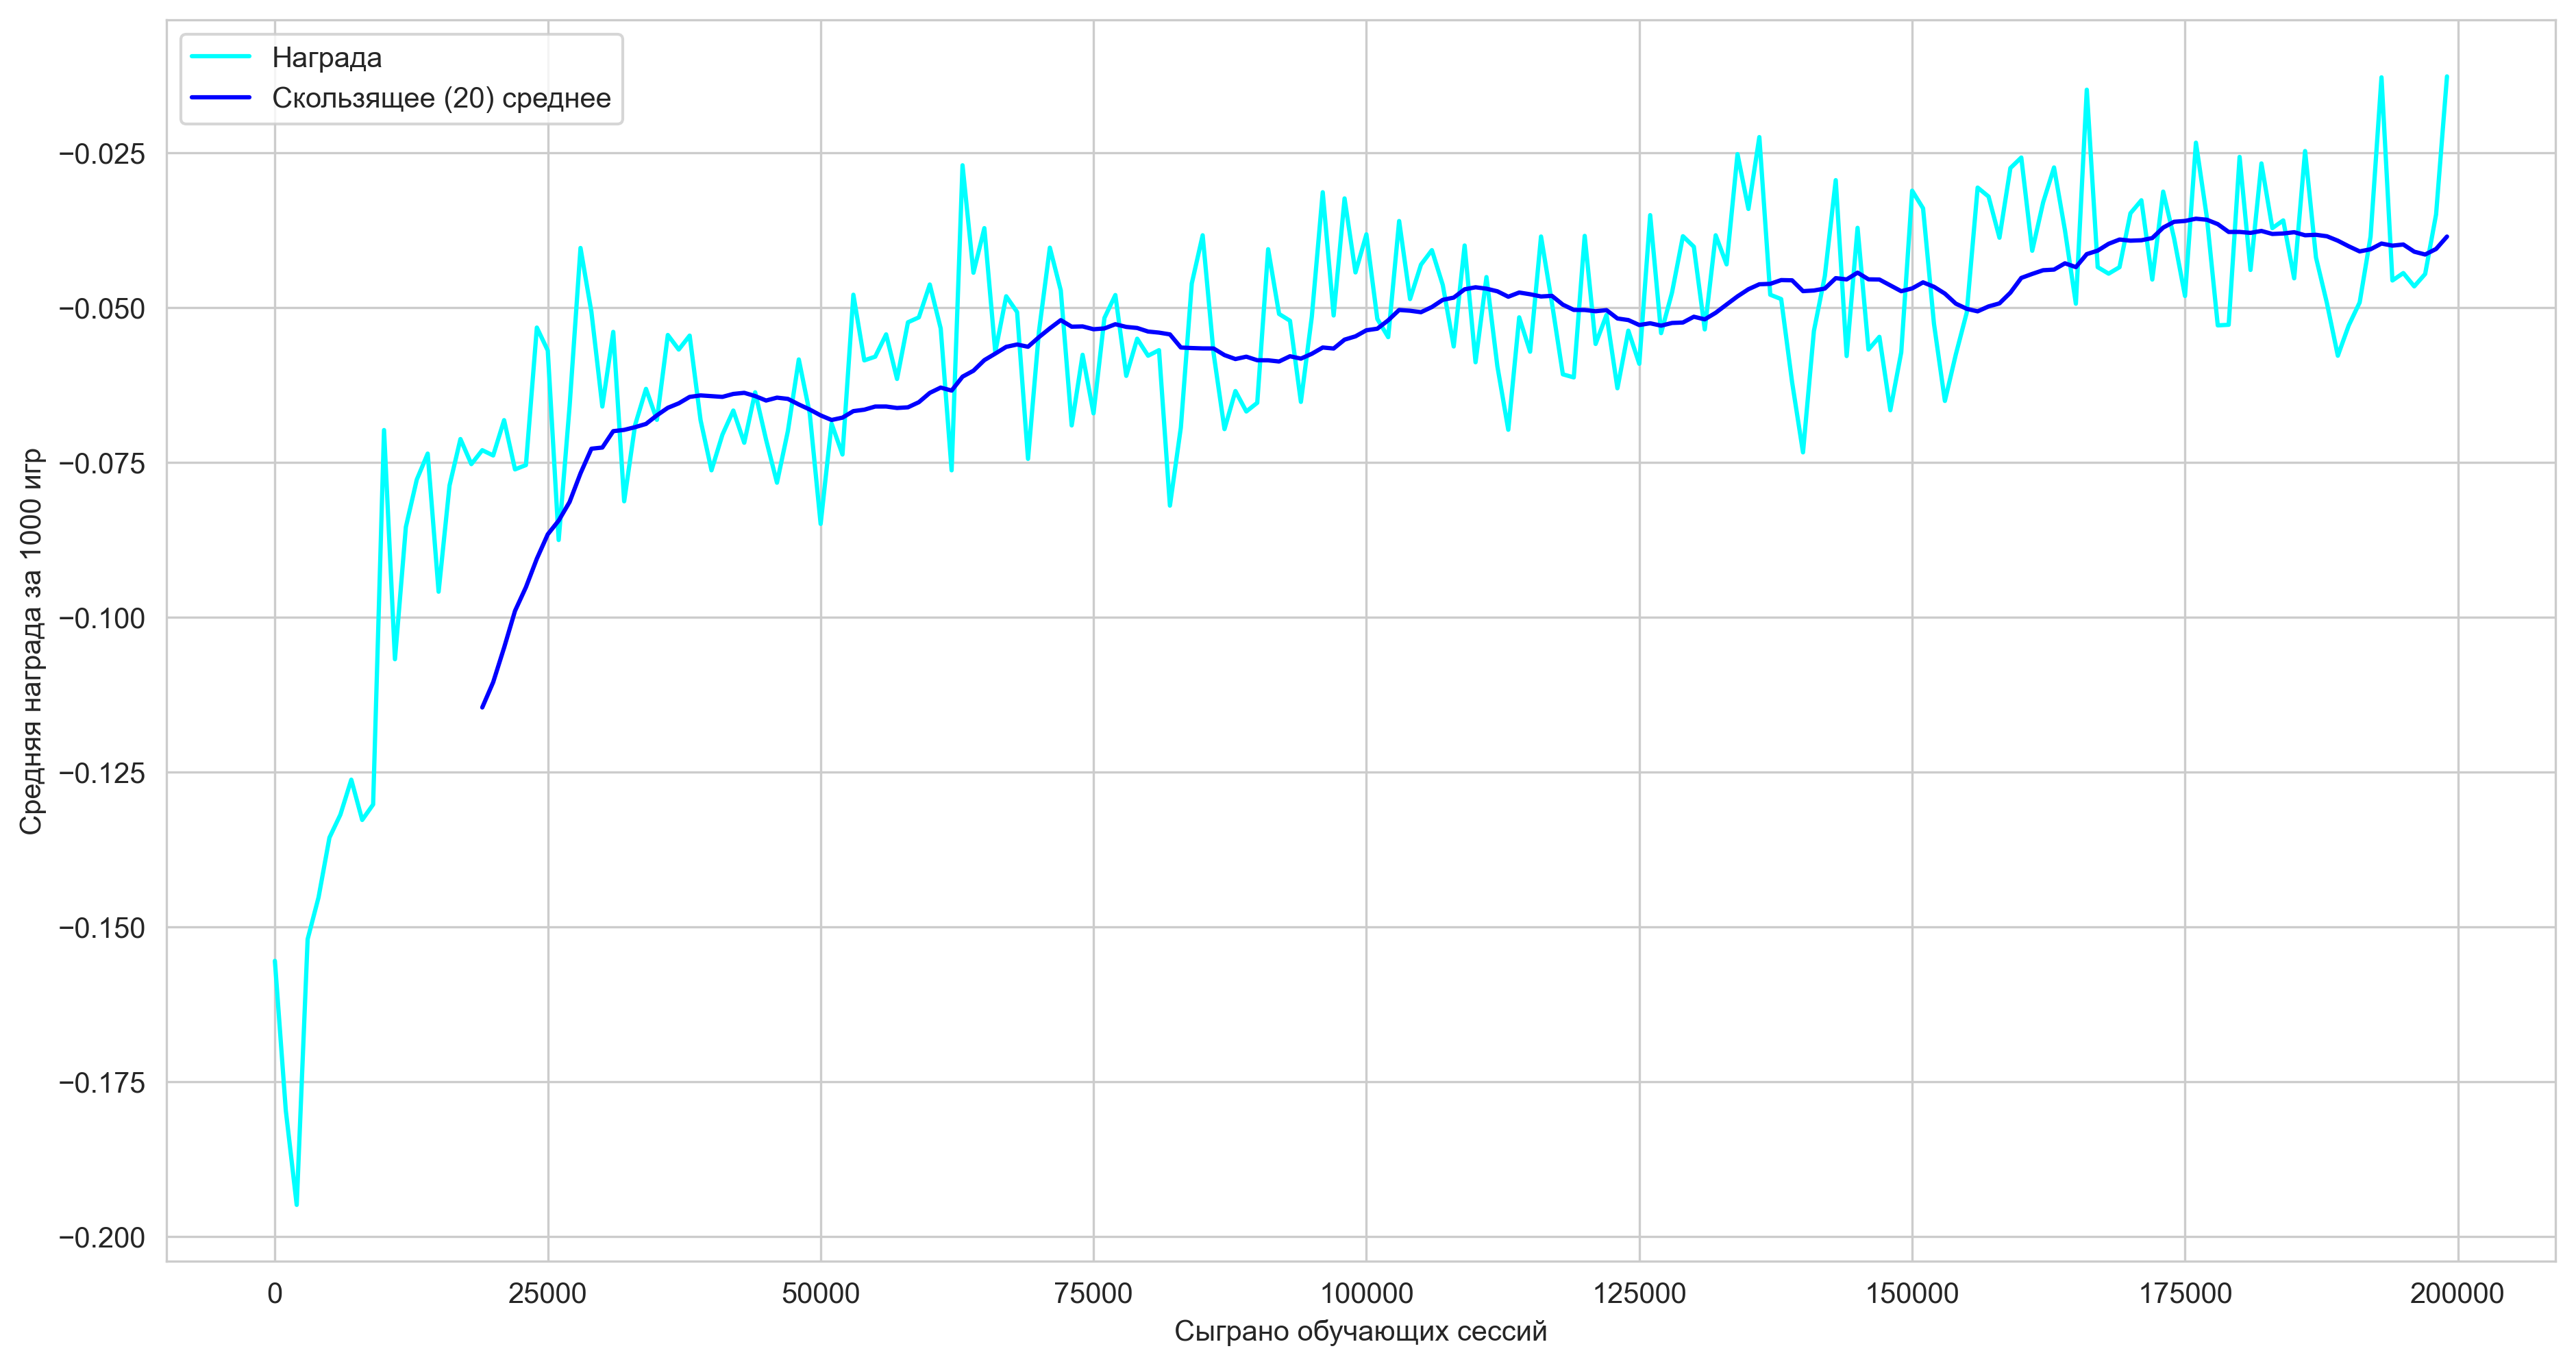

Финальная награда обученного агента равна -0.039 за 10000 игр


In [36]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

total_episodes = 200_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=20)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

  0%|          | 0/1000000 [00:00<?, ?it/s]

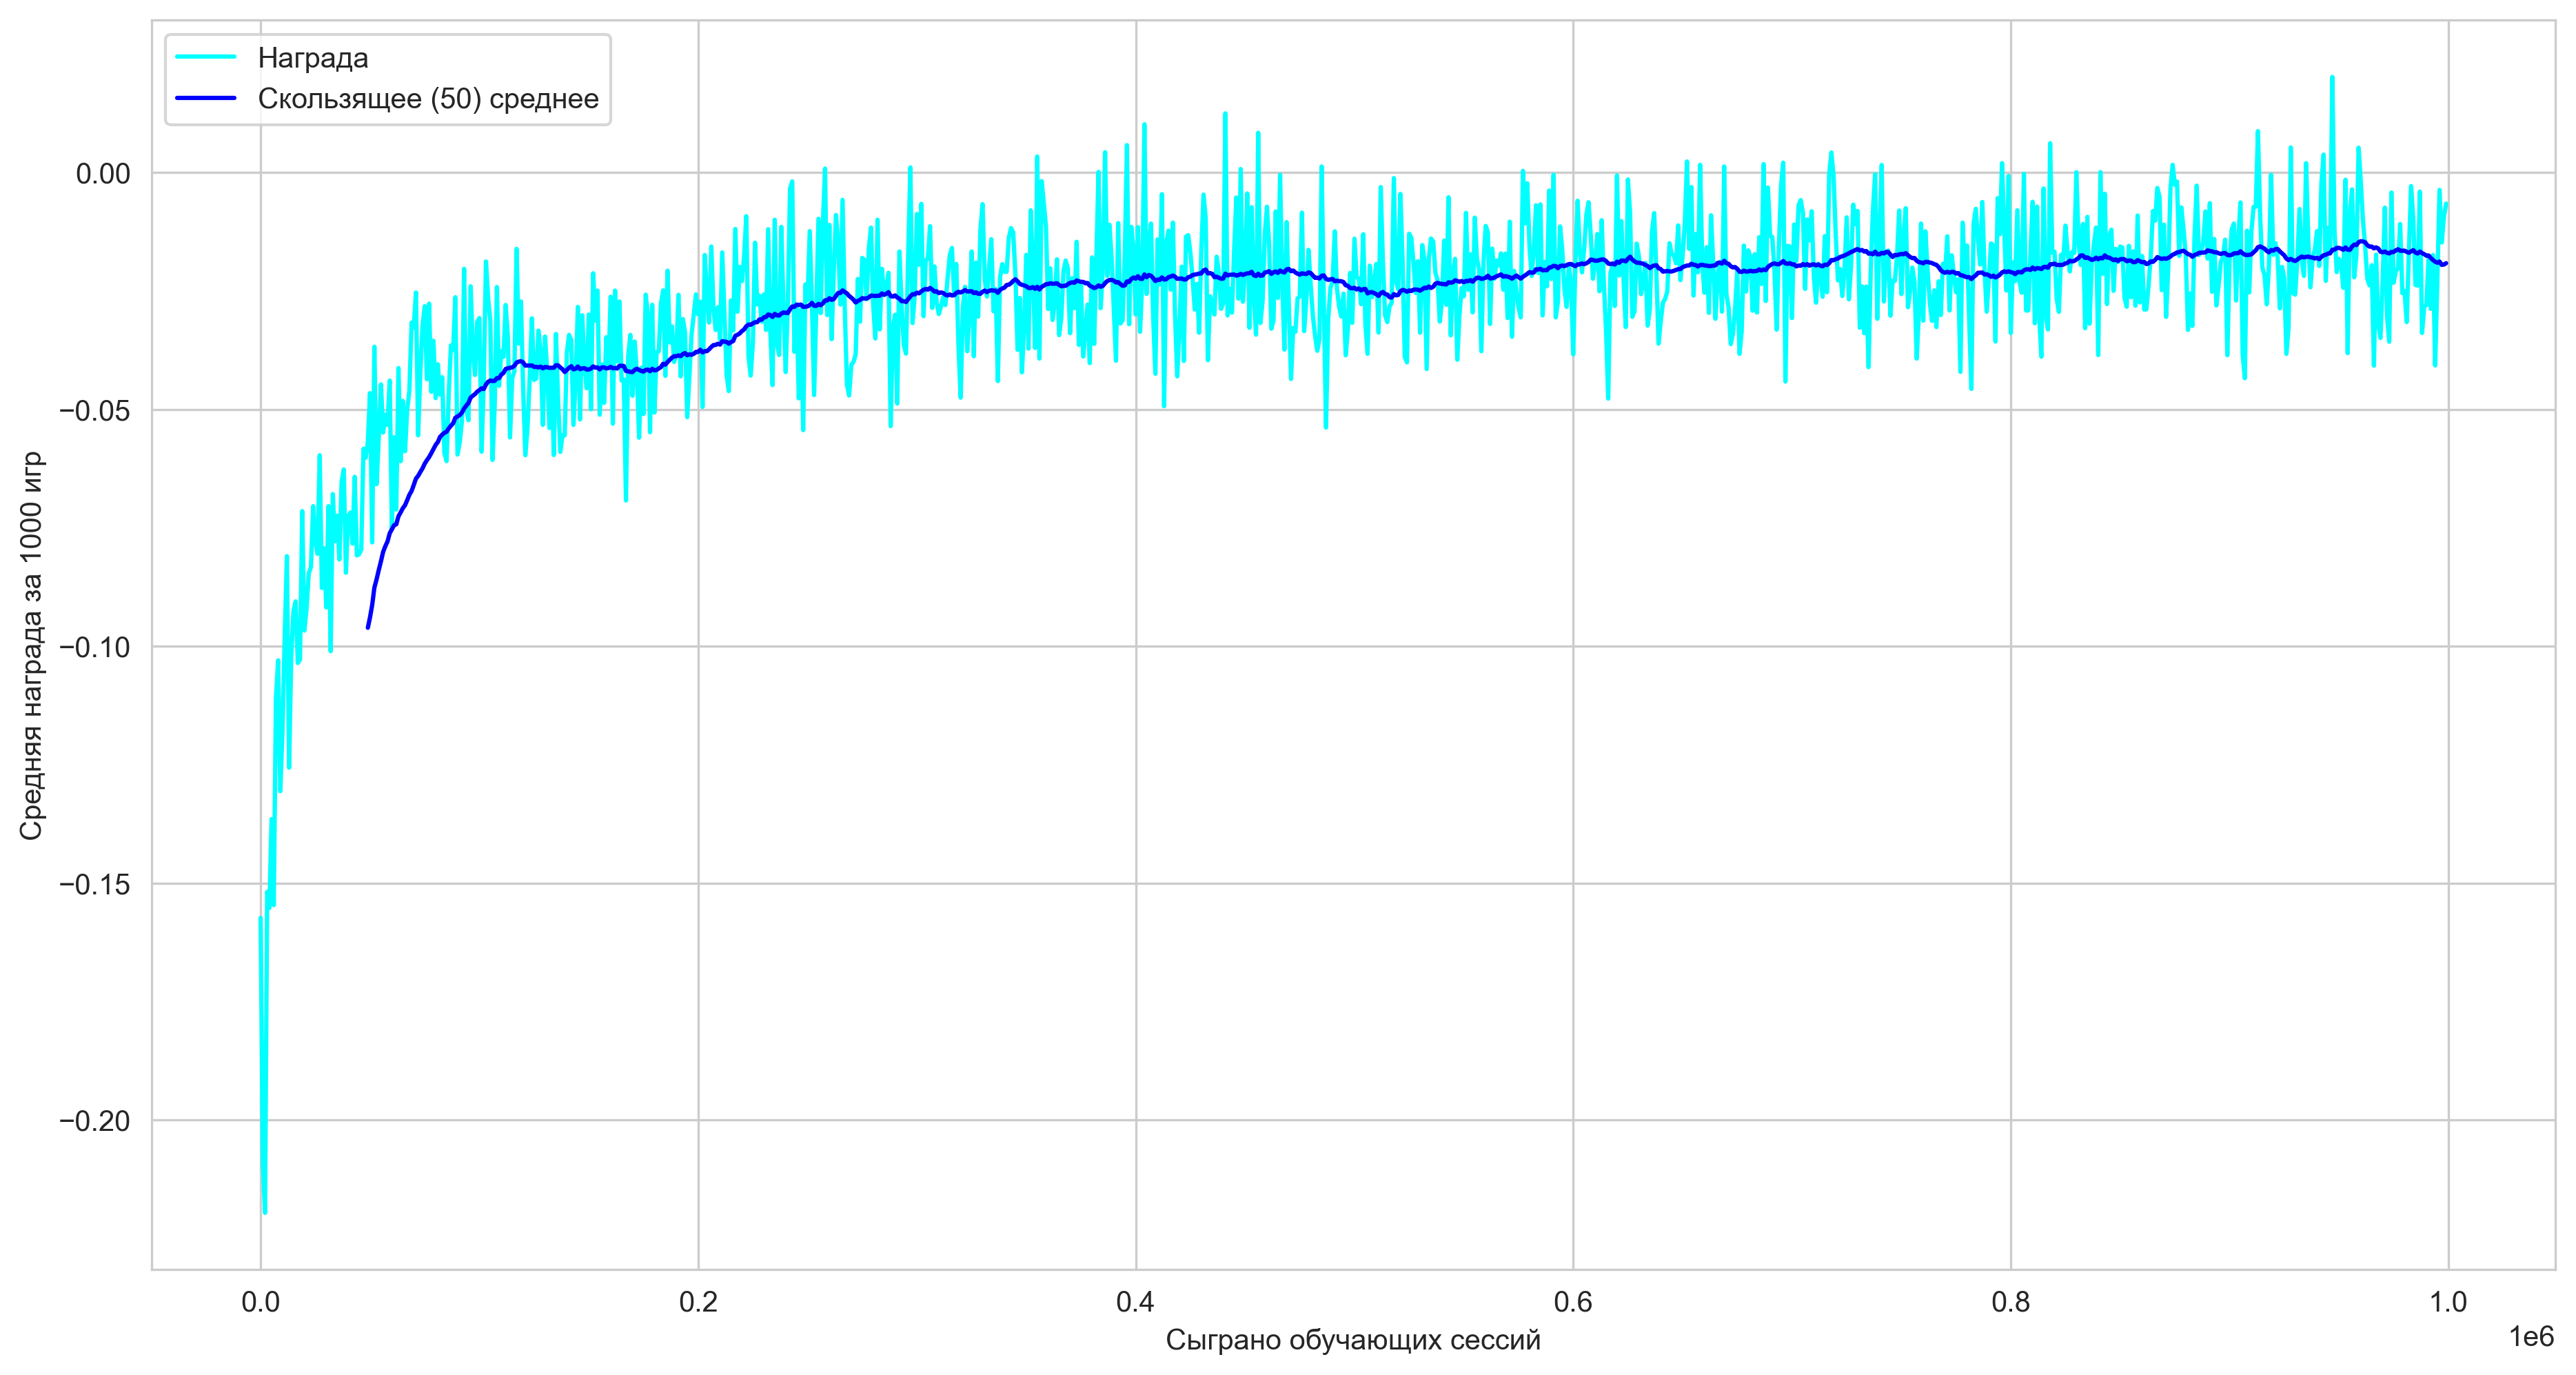

Финальная награда обученного агента равна -0.007 за 10000 игр


In [37]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

total_episodes = 1_000_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

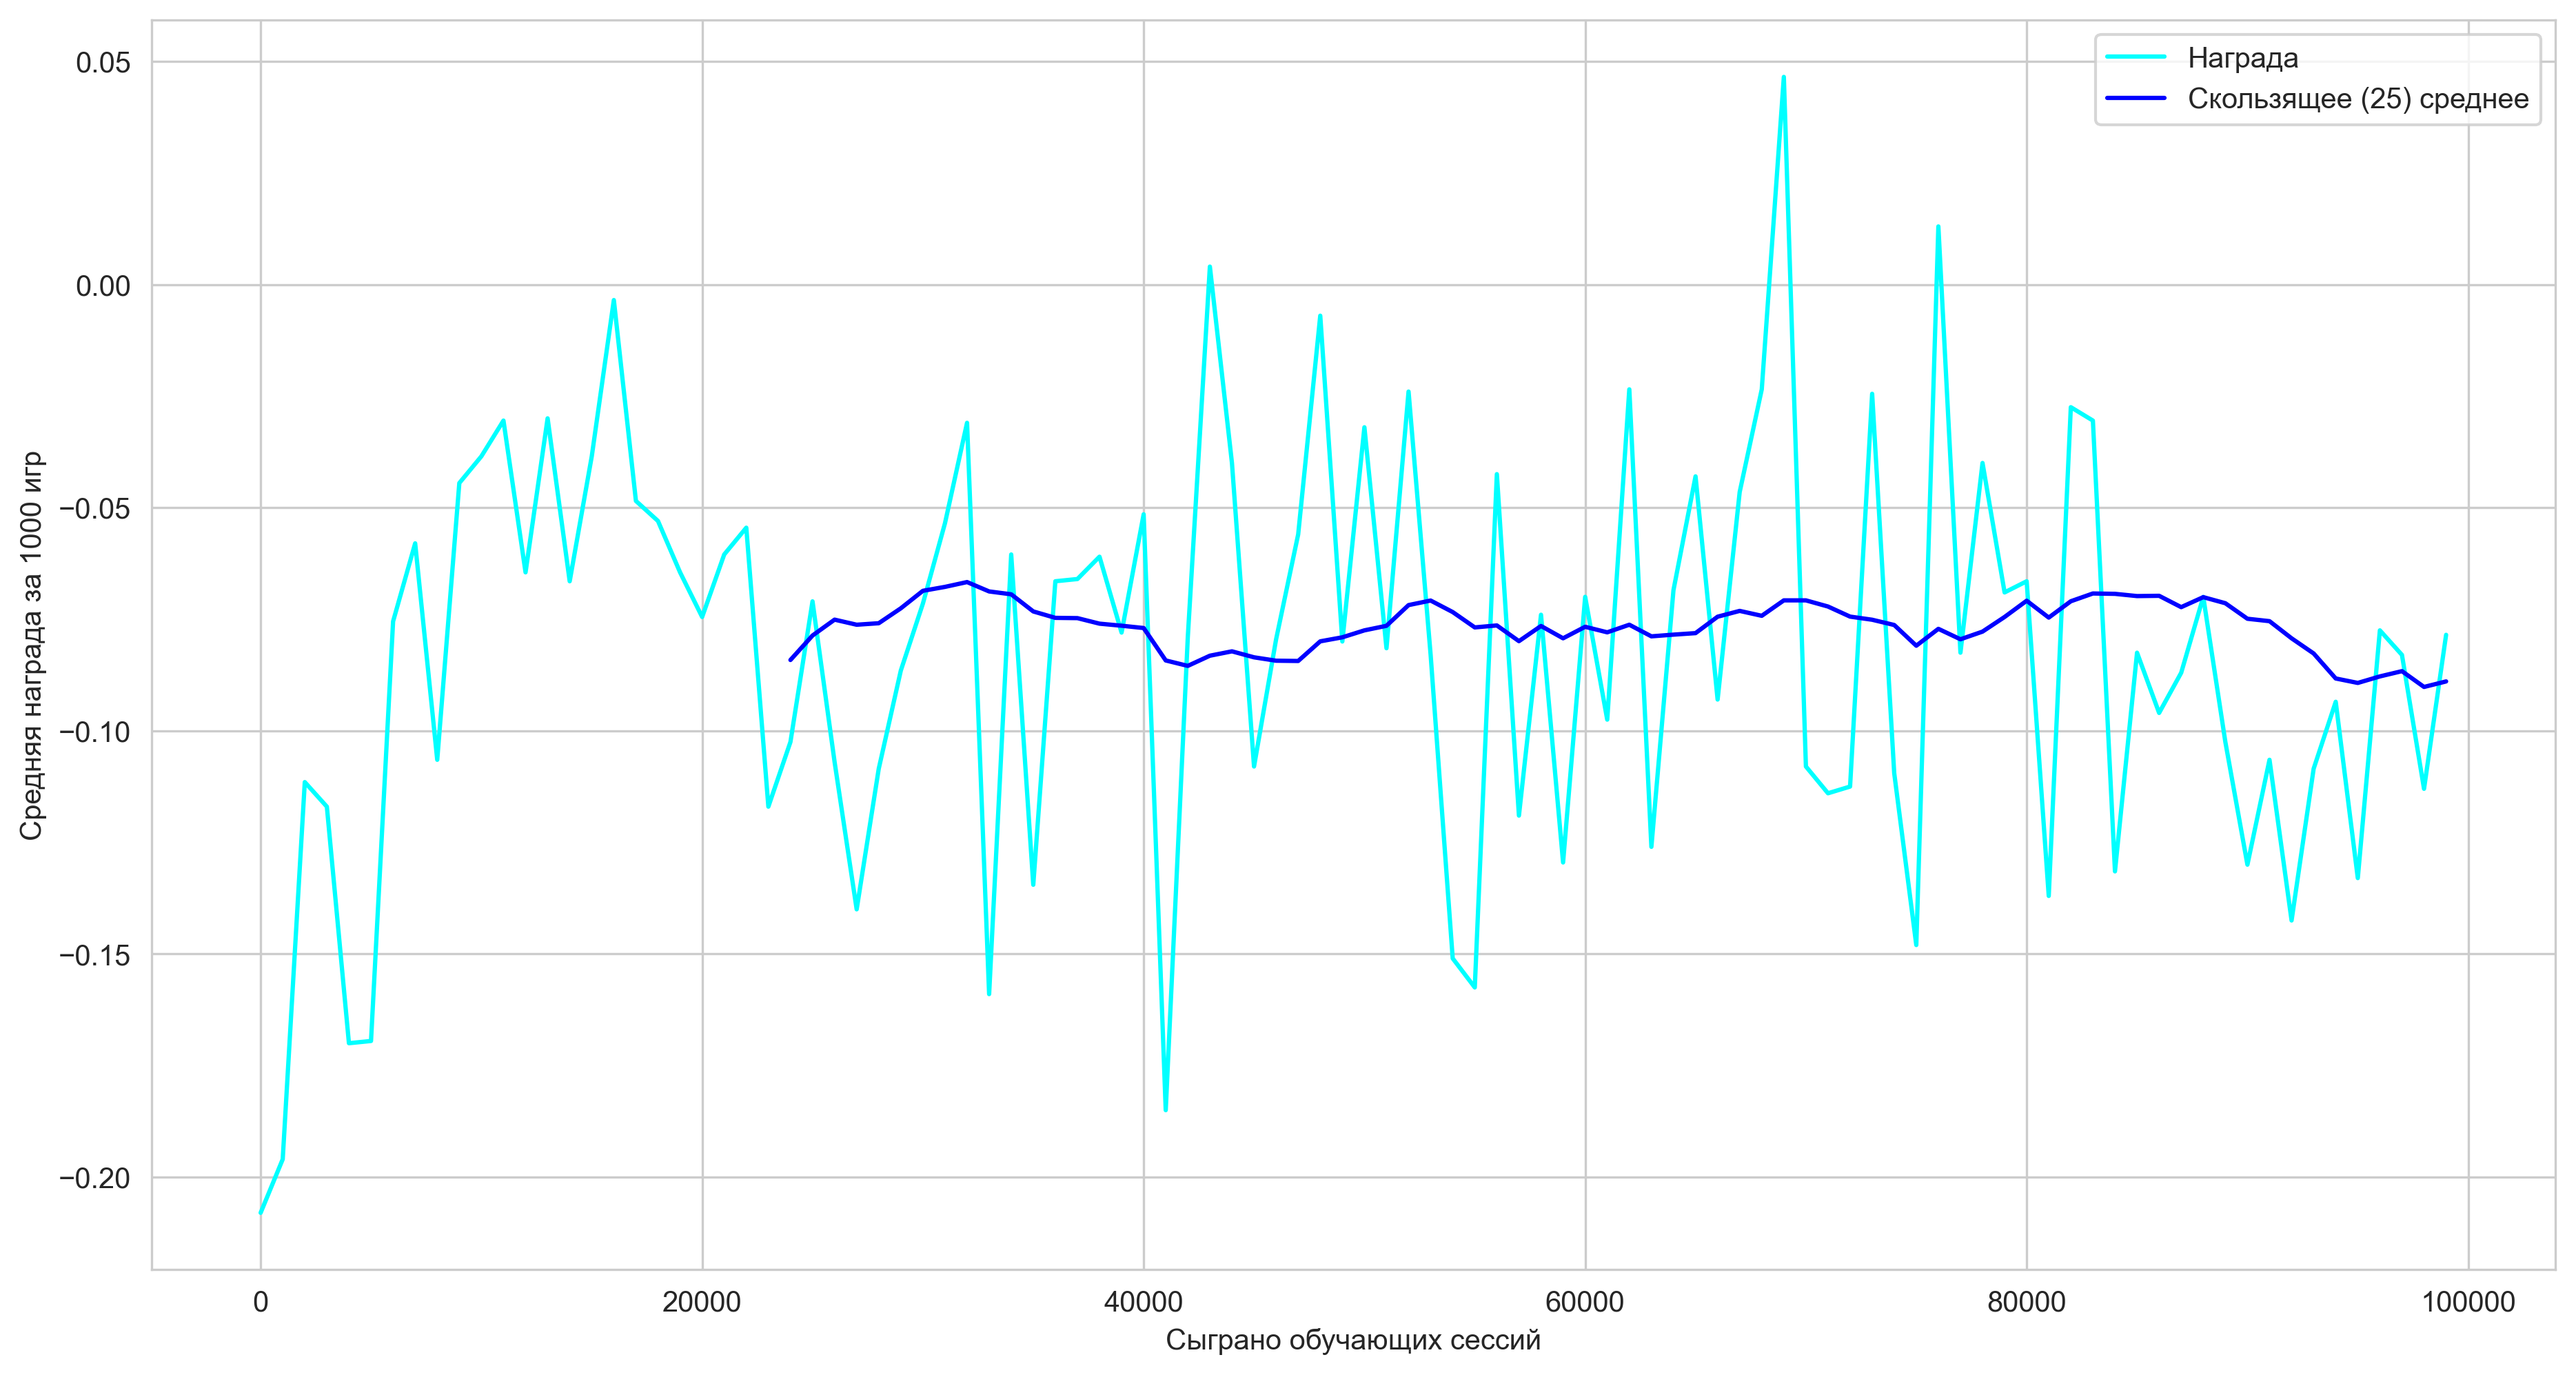

Финальная награда обученного агента равна -0.105 за 10000 игр


In [38]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

total_episodes = 100_000
gamma = 1
eps = 0.95
alpha = 0.01

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=25)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [39]:
def optuna_reward_Q_learning(trial): 
    eps = trial.suggest_uniform("eps", 0, 1)
    alpha = trial.suggest_uniform("alpha", 0, 1)
    
    agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

    env = BlackjackDoubleEnv(natural=True, double=True)

    total_episodes = 100_000
    games_check = 10_000
    period = 1e10
    gamma = 1

    agent, _ = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=period)
    
    res = np.mean(sample_games(agent, num_games=games_check, env=env))
    env.close()
    return res

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(optuna_reward_Q_learning, n_trials=100)

[I 2021-10-25 00:23:52,015] A new study created in memory with name: no-name-a5dda04e-804e-44a0-88bf-ca20cec2851a


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:01,228] Trial 0 finished with value: -0.16725 and parameters: {'eps': 0.8102612789700494, 'alpha': 0.976313413329156}. Best is trial 0 with value: -0.16725.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:10,620] Trial 1 finished with value: -0.15925 and parameters: {'eps': 0.684116870781387, 'alpha': 0.12780660370091712}. Best is trial 1 with value: -0.15925.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:20,708] Trial 2 finished with value: -0.1724 and parameters: {'eps': 0.5179369304681124, 'alpha': 0.13147510530985596}. Best is trial 1 with value: -0.15925.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:30,875] Trial 3 finished with value: -0.1411 and parameters: {'eps': 0.1342162809044185, 'alpha': 0.9740744741691097}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:40,056] Trial 4 finished with value: -0.1519 and parameters: {'eps': 0.8394261120207821, 'alpha': 0.3598207531712696}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:49,080] Trial 5 finished with value: -0.15005 and parameters: {'eps': 0.3898370029820869, 'alpha': 0.9679717376654424}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:24:57,967] Trial 6 finished with value: -0.1871 and parameters: {'eps': 0.2568501870642931, 'alpha': 0.7539727082631388}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:07,127] Trial 7 finished with value: -0.1663 and parameters: {'eps': 0.9763297681103758, 'alpha': 0.9579466361398069}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:16,238] Trial 8 finished with value: -0.20465 and parameters: {'eps': 0.7553790213884266, 'alpha': 0.9765314861952074}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:25,054] Trial 9 finished with value: -0.1973 and parameters: {'eps': 0.2199015927489485, 'alpha': 0.9451160760627676}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:34,238] Trial 10 finished with value: -0.15725 and parameters: {'eps': 0.043419634876502036, 'alpha': 0.5877374506247791}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:43,192] Trial 11 finished with value: -0.17155 and parameters: {'eps': 0.3544599387746423, 'alpha': 0.7309837842629593}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:25:52,983] Trial 12 finished with value: -0.1429 and parameters: {'eps': 0.002295475977670741, 'alpha': 0.7586620354729452}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:02,048] Trial 13 finished with value: -0.16305 and parameters: {'eps': 0.0403442208378646, 'alpha': 0.7564682556984448}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:11,622] Trial 14 finished with value: -0.1572 and parameters: {'eps': 0.007747257669609847, 'alpha': 0.5503912533864188}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:20,487] Trial 15 finished with value: -0.16595 and parameters: {'eps': 0.1685644449980982, 'alpha': 0.8074152999251716}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:29,560] Trial 16 finished with value: -0.1751 and parameters: {'eps': 0.11951726569193707, 'alpha': 0.4057356691466094}. Best is trial 3 with value: -0.1411.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:38,617] Trial 17 finished with value: -0.13385 and parameters: {'eps': 0.5429140224933172, 'alpha': 0.8269450867256968}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:47,702] Trial 18 finished with value: -0.14155 and parameters: {'eps': 0.5820218151503245, 'alpha': 0.6402963758114836}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:26:56,612] Trial 19 finished with value: -0.1637 and parameters: {'eps': 0.36618416060025183, 'alpha': 0.844628215038123}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:05,599] Trial 20 finished with value: -0.19125 and parameters: {'eps': 0.599281901944873, 'alpha': 0.8574163087992923}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:14,705] Trial 21 finished with value: -0.14595 and parameters: {'eps': 0.4940512203758314, 'alpha': 0.6448402576689596}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:23,762] Trial 22 finished with value: -0.13735 and parameters: {'eps': 0.5861281416048602, 'alpha': 0.6538077733993531}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:32,705] Trial 23 finished with value: -0.1827 and parameters: {'eps': 0.45761110652053383, 'alpha': 0.8752530864829583}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:41,790] Trial 24 finished with value: -0.16845 and parameters: {'eps': 0.6536625547553241, 'alpha': 0.4521477329415684}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:50,719] Trial 25 finished with value: -0.1545 and parameters: {'eps': 0.2642626233283252, 'alpha': 0.6833870974368429}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:27:59,877] Trial 26 finished with value: -0.15155 and parameters: {'eps': 0.4553555090062904, 'alpha': 0.3000343881012691}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:08,939] Trial 27 finished with value: -0.14235 and parameters: {'eps': 0.5691552789262441, 'alpha': 0.886069882754315}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:18,098] Trial 28 finished with value: -0.1751 and parameters: {'eps': 0.6656875186343657, 'alpha': 0.5300594328722996}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:27,245] Trial 29 finished with value: -0.17195 and parameters: {'eps': 0.7566899148312355, 'alpha': 0.803976065323539}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:36,339] Trial 30 finished with value: -0.1729 and parameters: {'eps': 0.9201573029323443, 'alpha': 0.8962549949461294}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:45,486] Trial 31 finished with value: -0.164 and parameters: {'eps': 0.5927832880801222, 'alpha': 0.6438349053529357}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:28:54,617] Trial 32 finished with value: -0.15085 and parameters: {'eps': 0.5378202872118024, 'alpha': 0.6154962570141028}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:03,645] Trial 33 finished with value: -0.194 and parameters: {'eps': 0.7161261114007401, 'alpha': 0.6978217705307863}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:12,760] Trial 34 finished with value: -0.16475 and parameters: {'eps': 0.6320467313910878, 'alpha': 0.48303492248319124}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:21,680] Trial 35 finished with value: -0.19115 and parameters: {'eps': 0.4468919557847518, 'alpha': 0.8045123055193244}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:30,868] Trial 36 finished with value: -0.1597 and parameters: {'eps': 0.8154657039536912, 'alpha': 0.2862658830592193}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:39,902] Trial 37 finished with value: -0.17895 and parameters: {'eps': 0.523285100760807, 'alpha': 0.6970440084322314}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:48,883] Trial 38 finished with value: -0.1424 and parameters: {'eps': 0.30537005644337223, 'alpha': 0.5762879518666861}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:29:57,861] Trial 39 finished with value: -0.1572 and parameters: {'eps': 0.404948064784488, 'alpha': 0.9105847982220432}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:06,906] Trial 40 finished with value: -0.13425 and parameters: {'eps': 0.5558111432562662, 'alpha': 0.9430676879161728}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:15,984] Trial 41 finished with value: -0.15935 and parameters: {'eps': 0.5653777325466397, 'alpha': 0.9973119169386411}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:25,076] Trial 42 finished with value: -0.15825 and parameters: {'eps': 0.7272835987298492, 'alpha': 0.9491095515466582}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:34,064] Trial 43 finished with value: -0.1955 and parameters: {'eps': 0.4954377315035824, 'alpha': 0.931969522749087}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:43,076] Trial 44 finished with value: -0.1572 and parameters: {'eps': 0.6174035575297558, 'alpha': 0.9992578416807414}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:30:52,181] Trial 45 finished with value: -0.1662 and parameters: {'eps': 0.7014874505391073, 'alpha': 0.8162878484792242}. Best is trial 17 with value: -0.13385.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:01,693] Trial 46 finished with value: -0.12335 and parameters: {'eps': 0.4098529039710269, 'alpha': 0.08649879208947692}. Best is trial 46 with value: -0.12335.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:11,279] Trial 47 finished with value: -0.1401 and parameters: {'eps': 0.11535345911624806, 'alpha': 0.13278770940710666}. Best is trial 46 with value: -0.12335.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:20,889] Trial 48 finished with value: -0.08 and parameters: {'eps': 0.3267206998794669, 'alpha': 0.003281840312924722}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:30,568] Trial 49 finished with value: -0.1267 and parameters: {'eps': 0.3115675254269216, 'alpha': 0.021889251213190755}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:40,195] Trial 50 finished with value: -0.13655 and parameters: {'eps': 0.3237149336068682, 'alpha': 0.006015616824400405}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:49,983] Trial 51 finished with value: -0.16835 and parameters: {'eps': 0.27069627697799964, 'alpha': 0.017091444080781965}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:31:59,632] Trial 52 finished with value: -0.1723 and parameters: {'eps': 0.3179238817753063, 'alpha': 0.0339773463407578}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:09,283] Trial 53 finished with value: -0.1305 and parameters: {'eps': 0.21770758930146383, 'alpha': 0.07674919374880126}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:18,915] Trial 54 finished with value: -0.1455 and parameters: {'eps': 0.1972011619934921, 'alpha': 0.08355255111213127}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:28,268] Trial 55 finished with value: -0.1543 and parameters: {'eps': 0.4094008647115964, 'alpha': 0.15331865642921924}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:37,661] Trial 56 finished with value: -0.16265 and parameters: {'eps': 0.21169201420334555, 'alpha': 0.17947164723939002}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:47,286] Trial 57 finished with value: -0.23615 and parameters: {'eps': 0.3462049682911441, 'alpha': 0.08379156642604664}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:32:56,624] Trial 58 finished with value: -0.1687 and parameters: {'eps': 0.16306382426851007, 'alpha': 0.21369151337624837}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:06,137] Trial 59 finished with value: -0.10845 and parameters: {'eps': 0.385420587696066, 'alpha': 0.06828700951651961}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:15,717] Trial 60 finished with value: -0.17605 and parameters: {'eps': 0.36340623249025367, 'alpha': 0.05884074778640964}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:25,230] Trial 61 finished with value: -0.18235 and parameters: {'eps': 0.28761187711911873, 'alpha': 0.0989811851738204}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:34,744] Trial 62 finished with value: -0.1752 and parameters: {'eps': 0.4294121909411224, 'alpha': 0.0517837414499274}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:44,090] Trial 63 finished with value: -0.1879 and parameters: {'eps': 0.24420698164942167, 'alpha': 0.20082968260409673}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:33:53,247] Trial 64 finished with value: -0.14785 and parameters: {'eps': 0.3857833792741988, 'alpha': 0.24569498085230468}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:02,620] Trial 65 finished with value: -0.169 and parameters: {'eps': 0.4873227991116984, 'alpha': 0.11135304789392429}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:12,061] Trial 66 finished with value: -0.1098 and parameters: {'eps': 0.22686396450387777, 'alpha': 0.0005910450900886537}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:21,654] Trial 67 finished with value: -0.11015 and parameters: {'eps': 0.08408635173949192, 'alpha': 0.0008172033420439989}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:31,484] Trial 68 finished with value: -0.1459 and parameters: {'eps': 0.048394880733961226, 'alpha': 0.06034488933299614}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:41,265] Trial 69 finished with value: -0.15845 and parameters: {'eps': 0.16040377422258417, 'alpha': 0.006862486152128049}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:34:50,874] Trial 70 finished with value: -0.1474 and parameters: {'eps': 0.09487024977107672, 'alpha': 0.15385633626212797}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:00,619] Trial 71 finished with value: -0.19995 and parameters: {'eps': 0.2382848466271292, 'alpha': 0.036120457747993516}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:10,001] Trial 72 finished with value: -0.1751 and parameters: {'eps': 0.33631117700540053, 'alpha': 0.11576680249203705}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:19,573] Trial 73 finished with value: -0.14355 and parameters: {'eps': 0.2989946359253874, 'alpha': 0.07277523336400354}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:29,351] Trial 74 finished with value: -0.14525 and parameters: {'eps': 0.18986255027589527, 'alpha': 0.028700044006743492}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:38,654] Trial 75 finished with value: -0.1586 and parameters: {'eps': 0.46628181207867836, 'alpha': 0.15074934303162252}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:48,468] Trial 76 finished with value: -0.1557 and parameters: {'eps': 0.23105778183717468, 'alpha': 0.005607264267425698}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:35:57,710] Trial 77 finished with value: -0.18605 and parameters: {'eps': 0.07428927646948452, 'alpha': 0.3478081823182916}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:07,468] Trial 78 finished with value: -0.2685 and parameters: {'eps': 0.13849175071343336, 'alpha': 0.0504329013317048}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:17,005] Trial 79 finished with value: -0.16245 and parameters: {'eps': 0.2752823506342808, 'alpha': 0.08758834856436583}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:26,396] Trial 80 finished with value: -0.17475 and parameters: {'eps': 0.41911978143434614, 'alpha': 0.12216970579733903}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:36,021] Trial 81 finished with value: -0.20415 and parameters: {'eps': 0.34817151146783676, 'alpha': 0.042171313268376975}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:45,499] Trial 82 finished with value: -0.19485 and parameters: {'eps': 0.5460308922374318, 'alpha': 0.0688022686782882}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:36:55,127] Trial 83 finished with value: -0.1837 and parameters: {'eps': 0.43177637249845424, 'alpha': 0.019007384071004517}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:04,135] Trial 84 finished with value: -0.1933 and parameters: {'eps': 0.3789409656516496, 'alpha': 0.41892044444467996}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:13,712] Trial 85 finished with value: -0.0839 and parameters: {'eps': 0.39848387439410876, 'alpha': 0.003745776211868286}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:23,207] Trial 86 finished with value: -0.0905 and parameters: {'eps': 0.3882056411567137, 'alpha': 0.002050217903155077}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:32,701] Trial 87 finished with value: -0.08865 and parameters: {'eps': 0.39680567022630375, 'alpha': 0.002871876174421386}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:42,369] Trial 88 finished with value: -0.17685 and parameters: {'eps': 0.37842210799822906, 'alpha': 0.03165862673579112}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:37:51,962] Trial 89 finished with value: -0.15065 and parameters: {'eps': 0.3995287475595462, 'alpha': 0.008221772435568058}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:01,395] Trial 90 finished with value: -0.1924 and parameters: {'eps': 0.31527357538442824, 'alpha': 0.10066533398390527}. Best is trial 48 with value: -0.08.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:10,752] Trial 91 finished with value: -0.05345 and parameters: {'eps': 0.4620537367495816, 'alpha': 0.0006669276870936514}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:20,282] Trial 92 finished with value: -0.06035 and parameters: {'eps': 0.471437866043581, 'alpha': 0.0019615804454581887}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:29,763] Trial 93 finished with value: -0.2079 and parameters: {'eps': 0.483399895348365, 'alpha': 0.05015960977131824}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:39,298] Trial 94 finished with value: -0.09095 and parameters: {'eps': 0.4442019059951262, 'alpha': 0.0034745674153880295}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:48,820] Trial 95 finished with value: -0.0551 and parameters: {'eps': 0.44321671253351325, 'alpha': 0.002928721943377303}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:38:58,354] Trial 96 finished with value: -0.1808 and parameters: {'eps': 0.5254262103780871, 'alpha': 0.03357841559445307}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:39:07,888] Trial 97 finished with value: -0.109 and parameters: {'eps': 0.4528299543857872, 'alpha': 0.003128163837583937}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:39:17,485] Trial 98 finished with value: -0.18585 and parameters: {'eps': 0.4434458147099661, 'alpha': 0.039128285238222336}. Best is trial 91 with value: -0.05345.


  0%|          | 0/100000 [00:00<?, ?it/s]

[I 2021-10-25 00:39:27,018] Trial 99 finished with value: -0.1568 and parameters: {'eps': 0.46980664544955675, 'alpha': 0.06292281367853794}. Best is trial 91 with value: -0.05345.


  0%|          | 0/300000 [00:00<?, ?it/s]

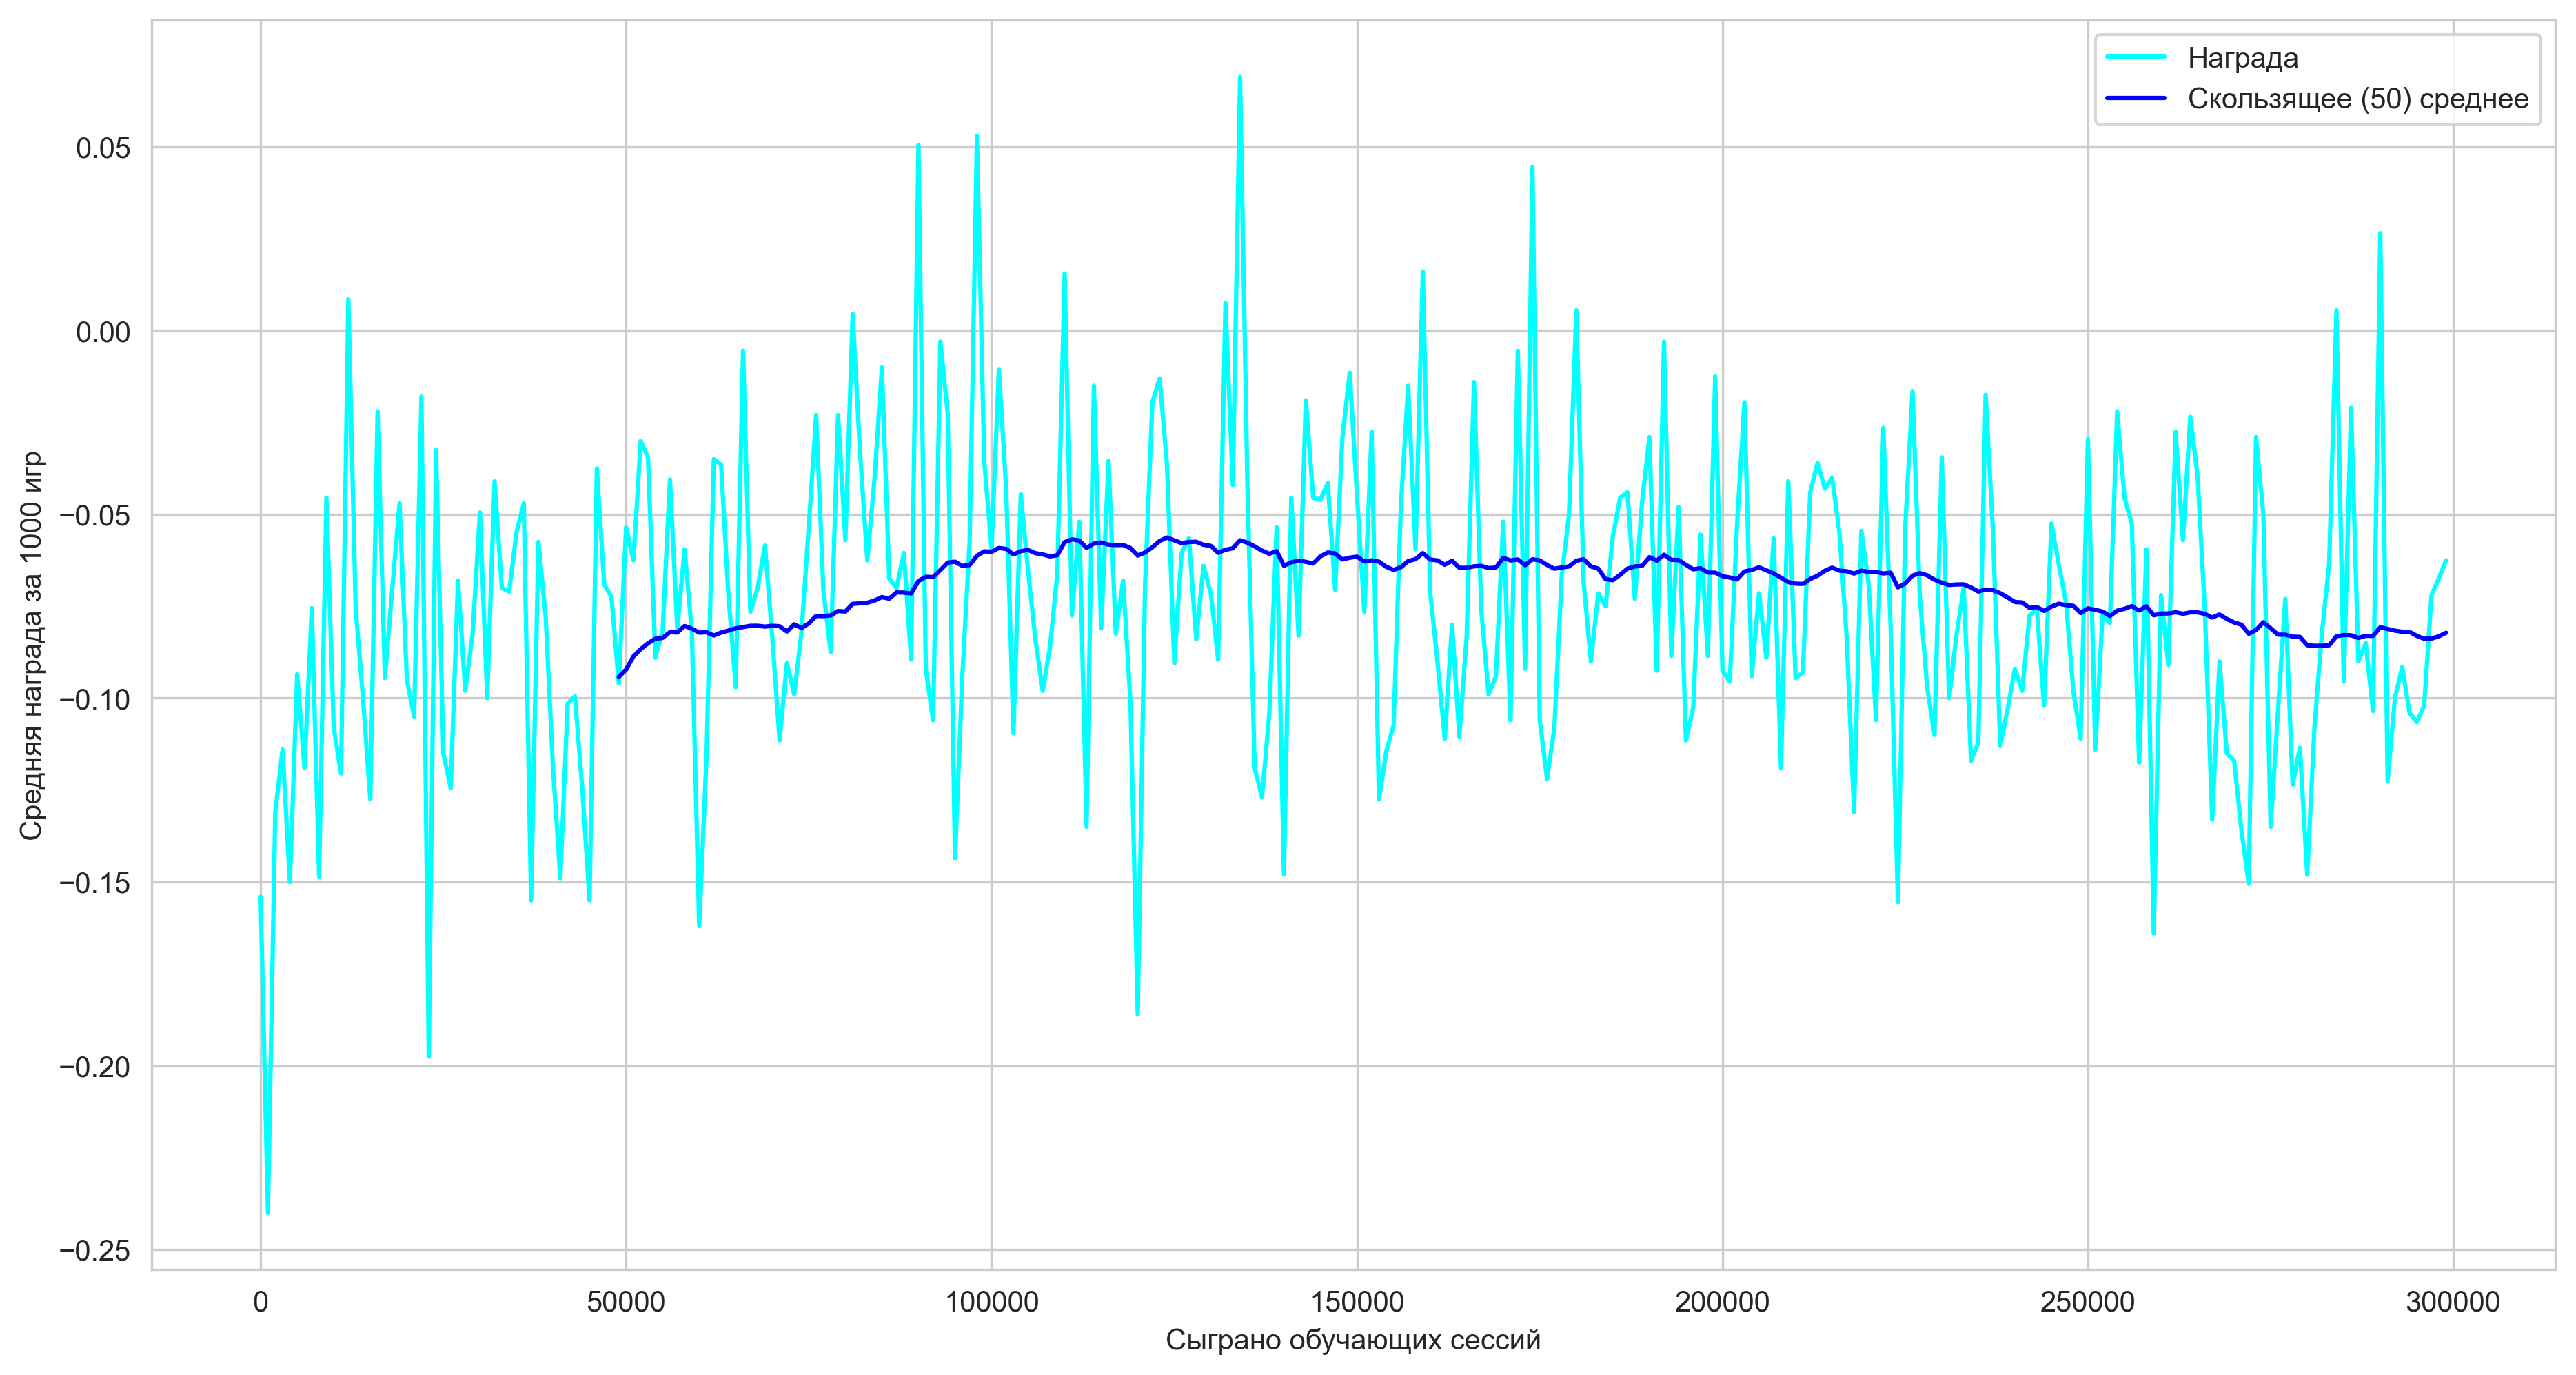

Финальная награда обученного агента равна -0.056 за 10000 игр


In [41]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

total_episodes = 300_000
gamma = 1
eps = study.best_params["eps"]
alpha = study.best_params["alpha"]

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha,
                                      n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.  

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
  
https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [42]:
from BlackJackCount import BlackjackCountEnv
# Система подсчета - "Половинки" на целых числах из статьи Википедии
env = BlackjackCountEnv(natural=True, double=True)

In [43]:
# Пример работы окружения
print(env.reset())
print(env.step(2))

(18, 10, False, -3)
((23, 10, False, 0), -2.0, True, {})


### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [44]:
# constants
nA = 3
nS = 380 * 89

In [45]:
for _ in range(10):
    env = BlackjackDoubleEnv(natural=True, double=True)
    states = collect_states(env, NUM_GAMES=30_000)
    if len(states) == 380:
        break
len(states)

380

In [46]:
state_list = []
for state in states:
    for score in range(-44, 45):
        state_list.append((*state, score))
len(state_list) == nS

True

In [47]:
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

  0%|          | 0/100000 [00:00<?, ?it/s]

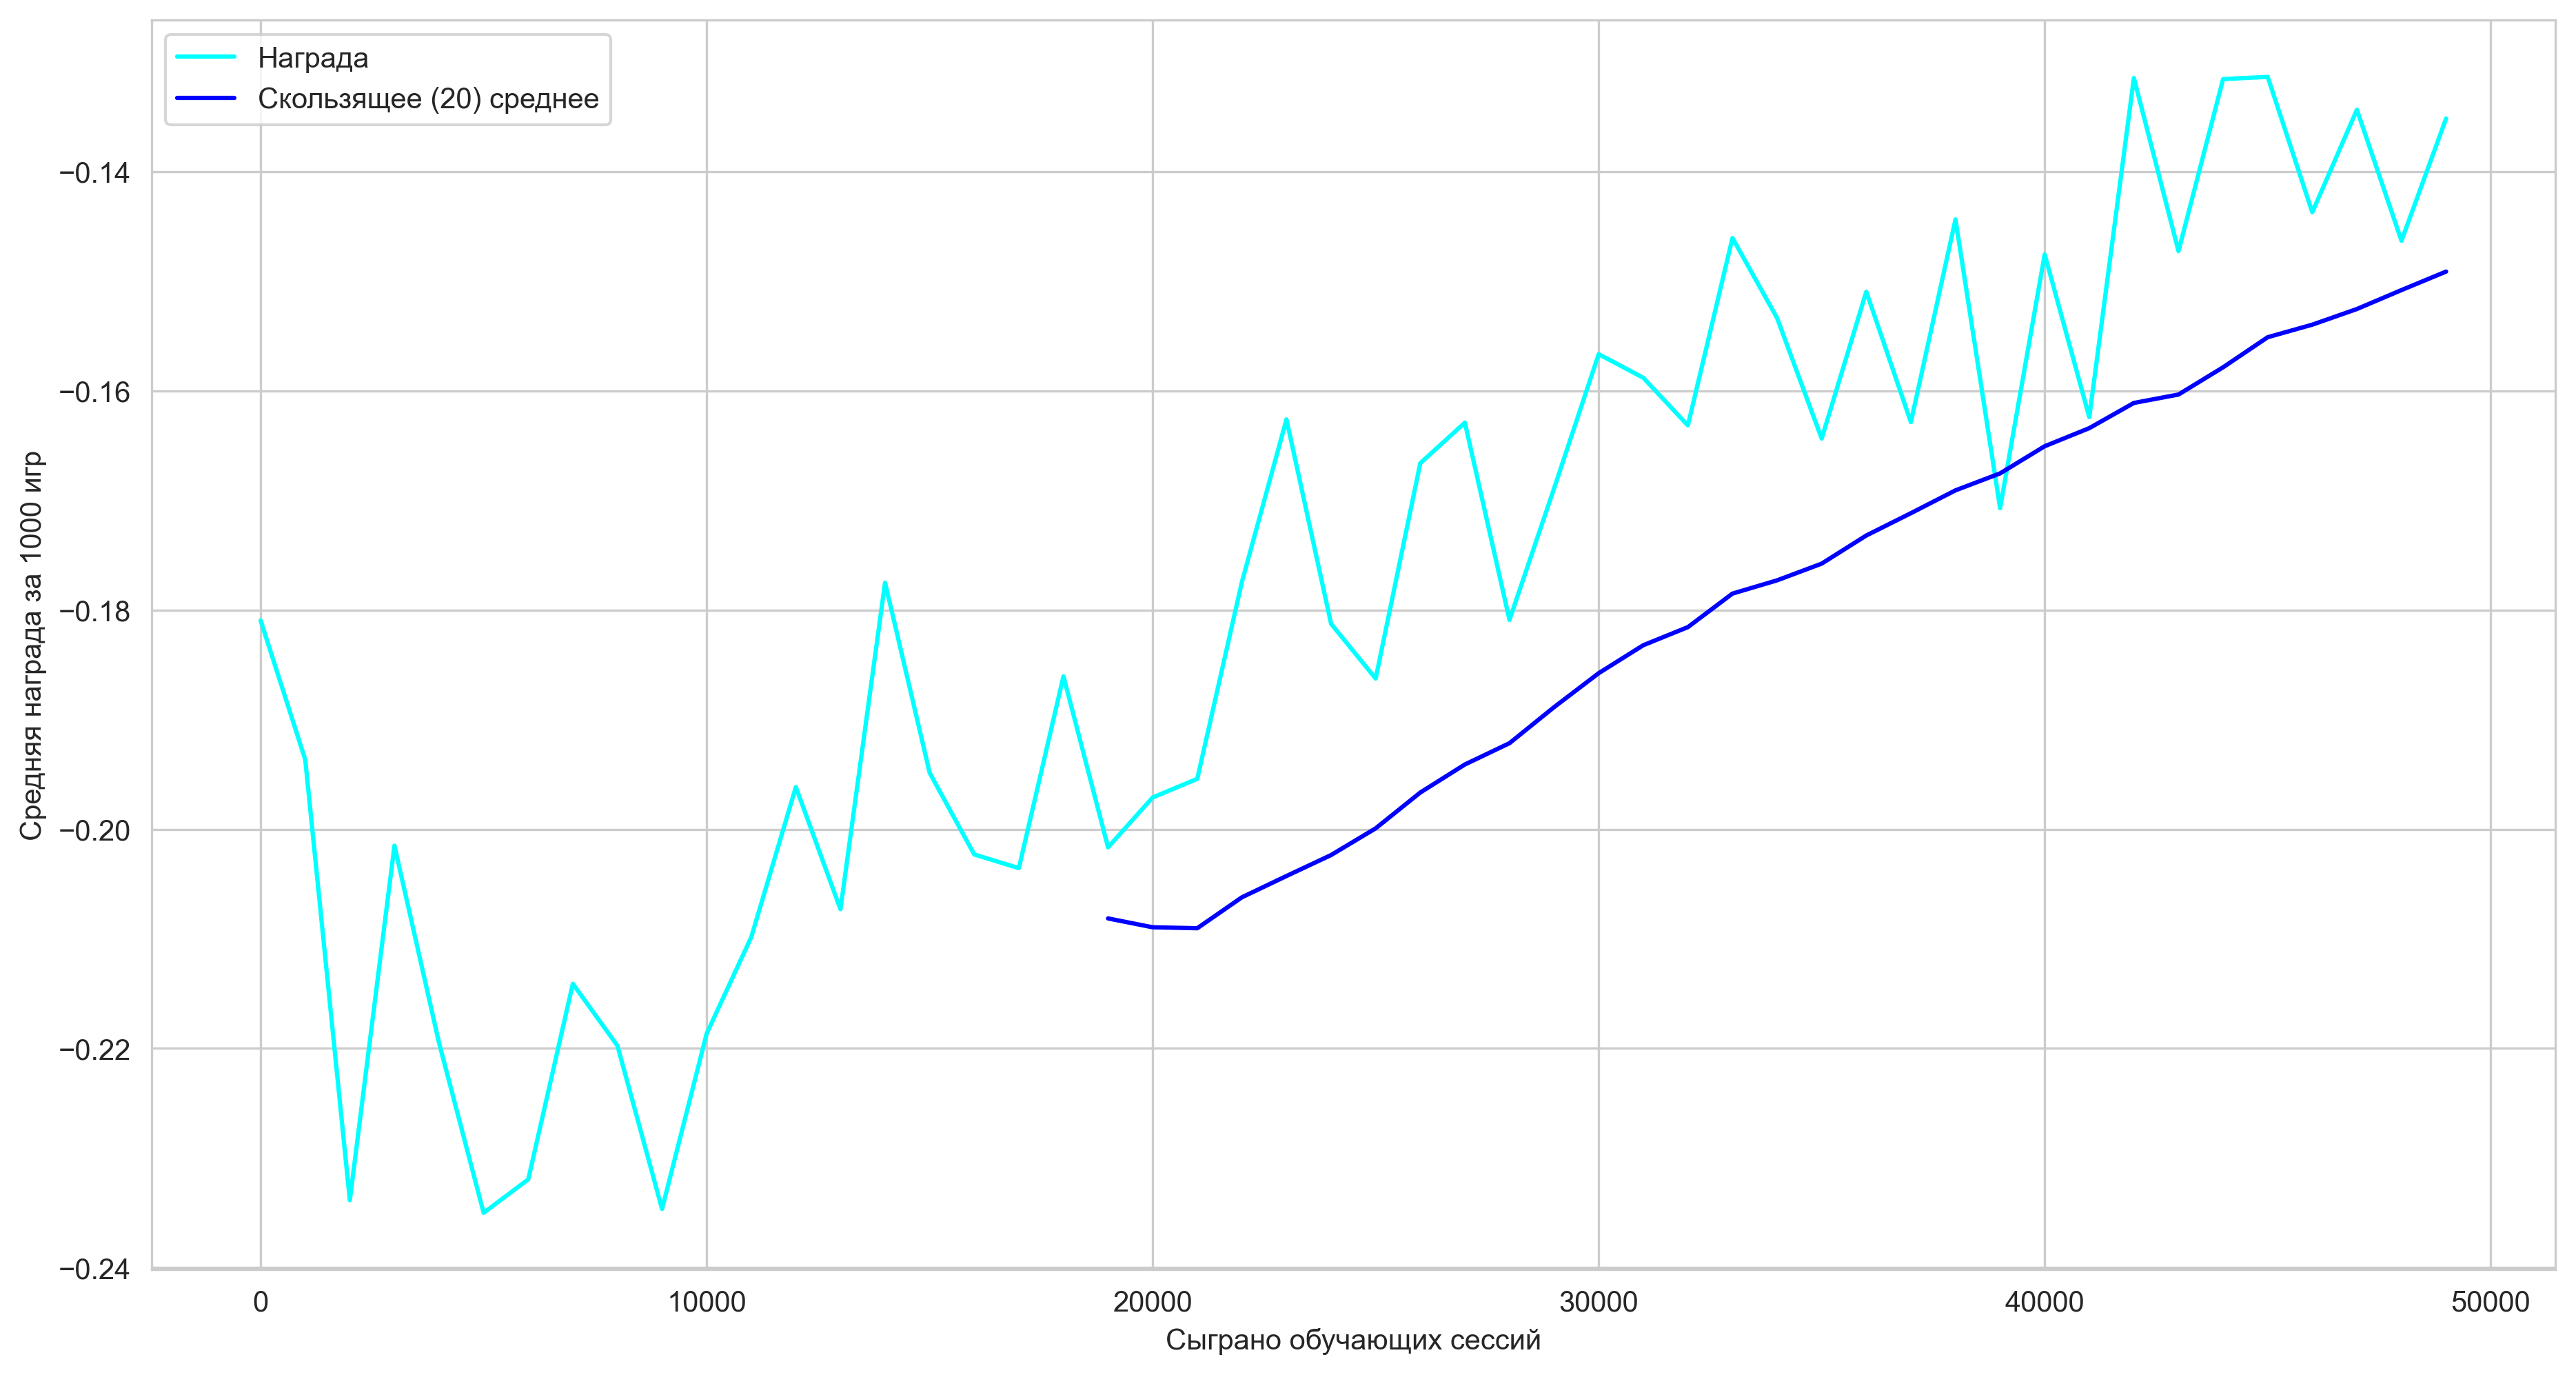

Финальная награда обученного агента равна -0.123 за 10000 игр


In [48]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 2_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=20)

res = np.mean(sample_games(agent, num_games=num_games, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [49]:
# Видно, что обучение не достигло своей цели, но матриц много, они большие, поэтому считается уж слишком долго.

  0%|          | 0/100000 [00:00<?, ?it/s]

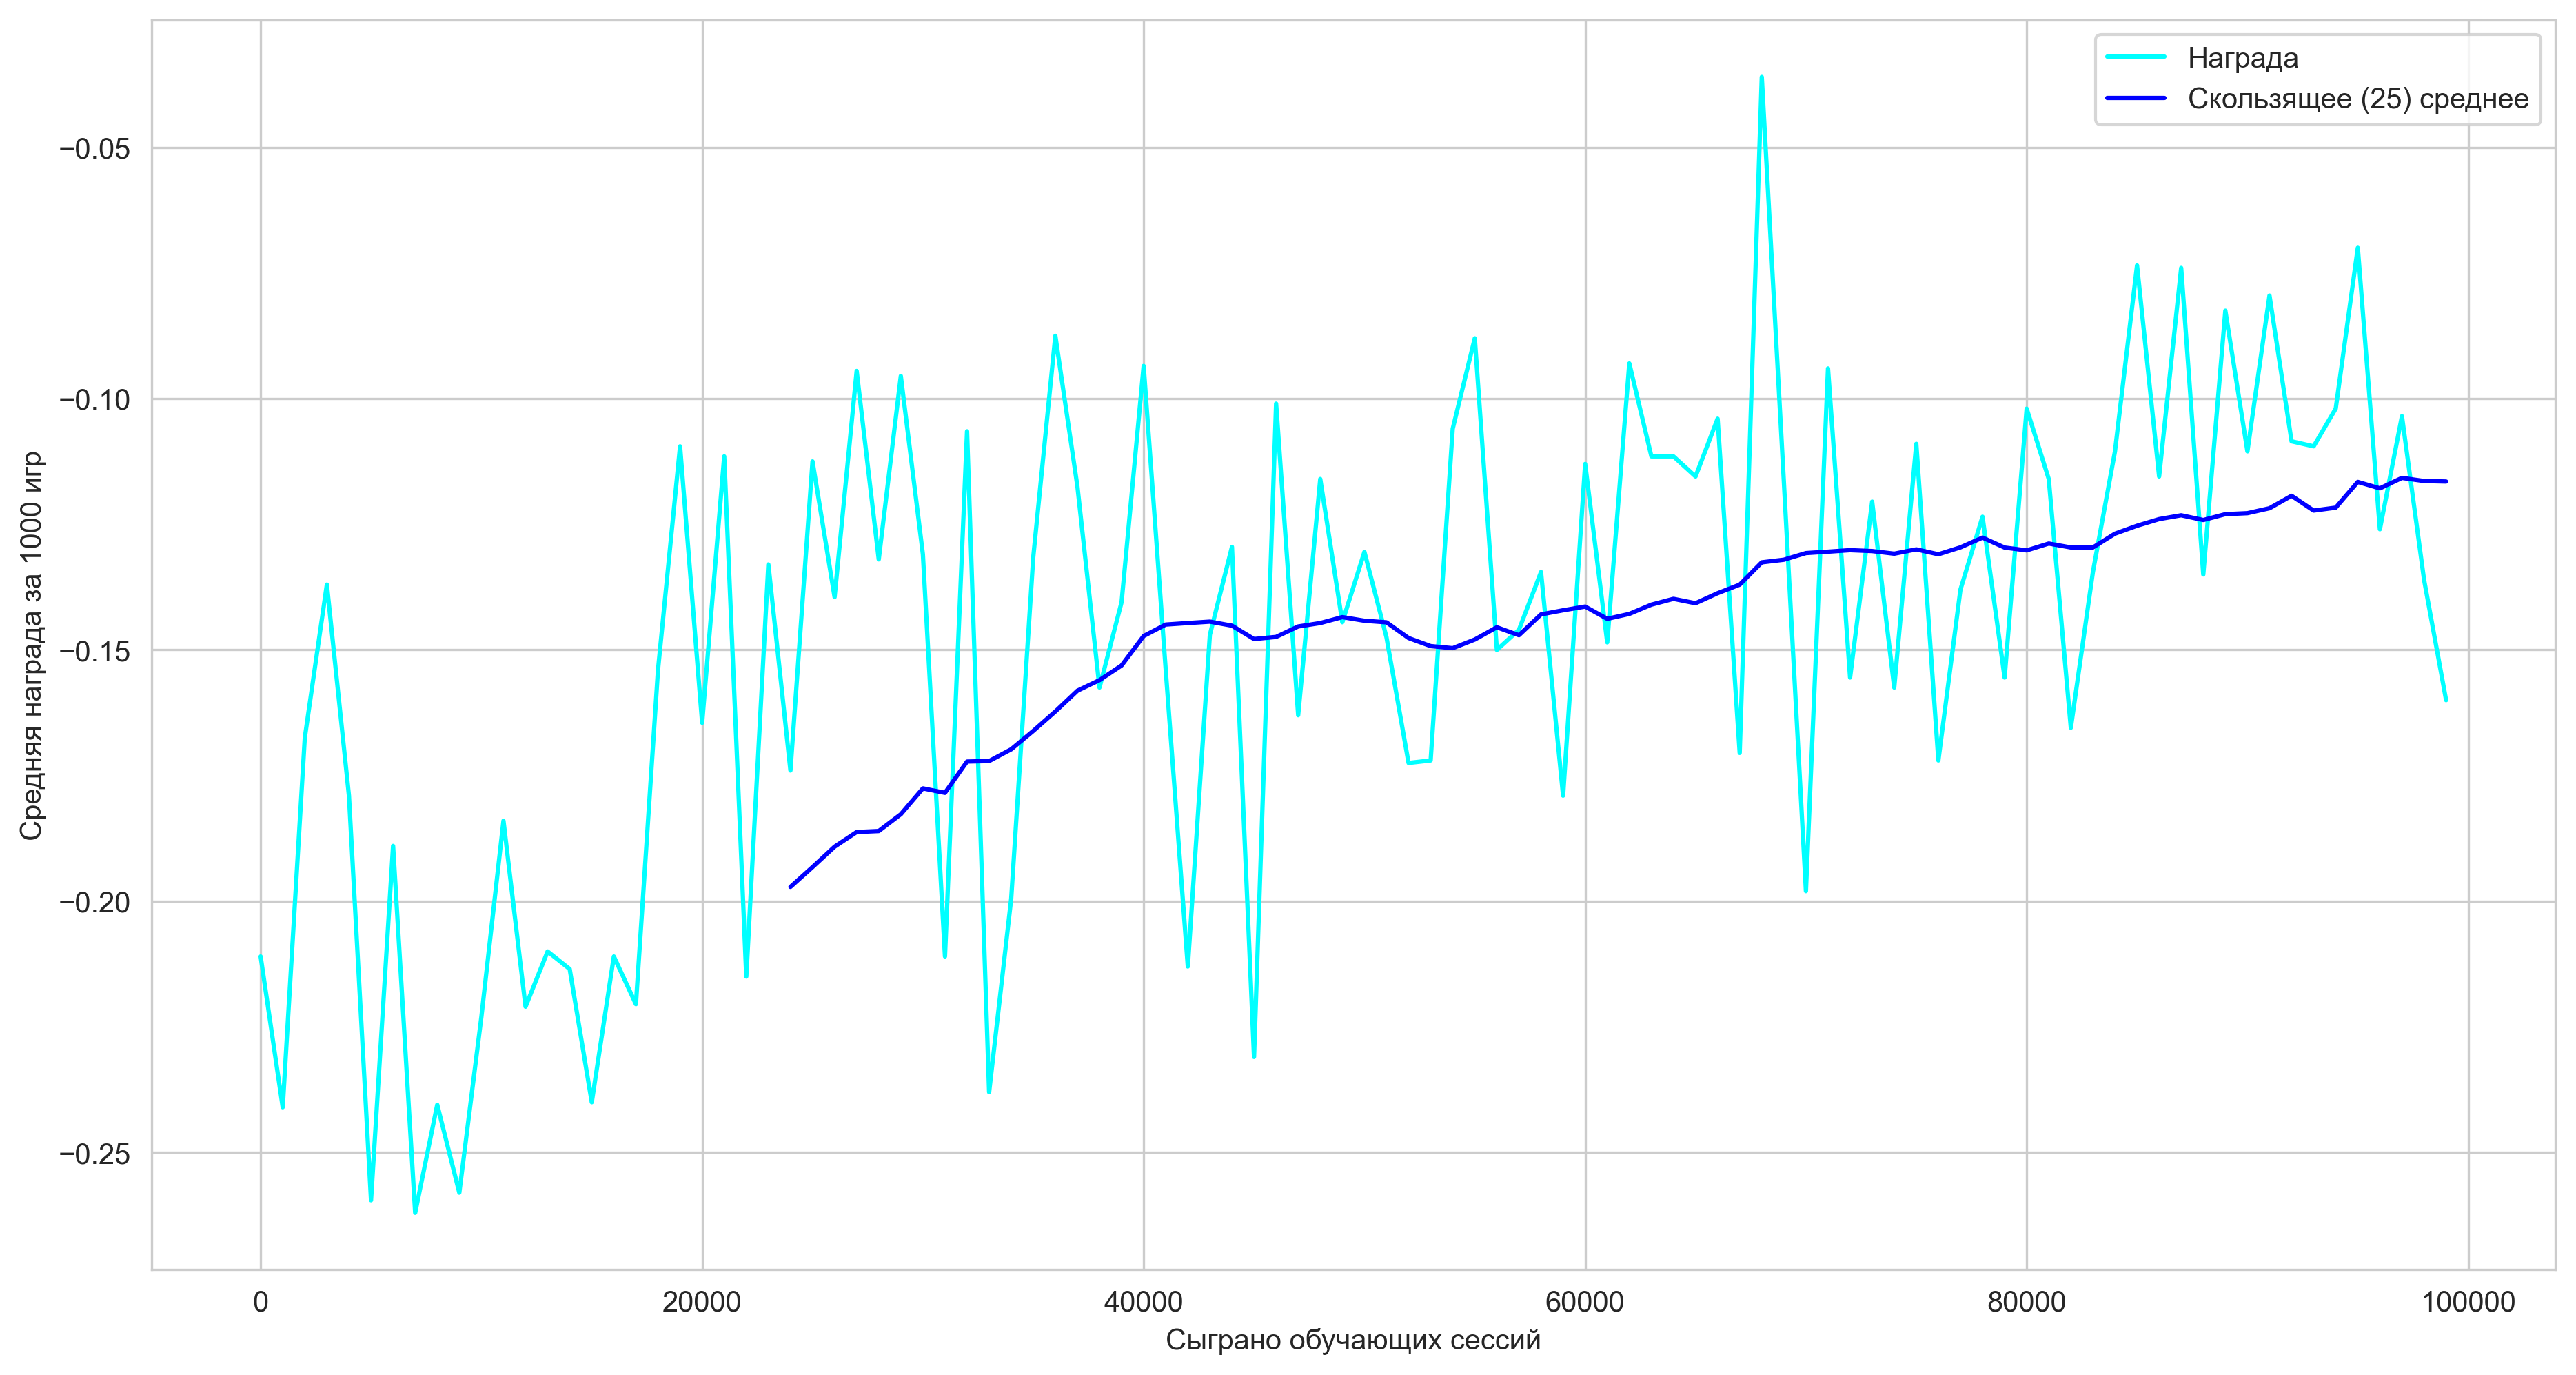

Финальная награда обученного агента равна -0.094 за 10000 игр


In [50]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

total_episodes = 100_000
gamma = 1
eps = 0.95
alpha = 0.001

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=25)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()

In [51]:
# Видно, что обучение не закончено, попробуем сделать больше экспериментов. По времени получается вполне адекватно.

  0%|          | 0/2000000 [00:00<?, ?it/s]

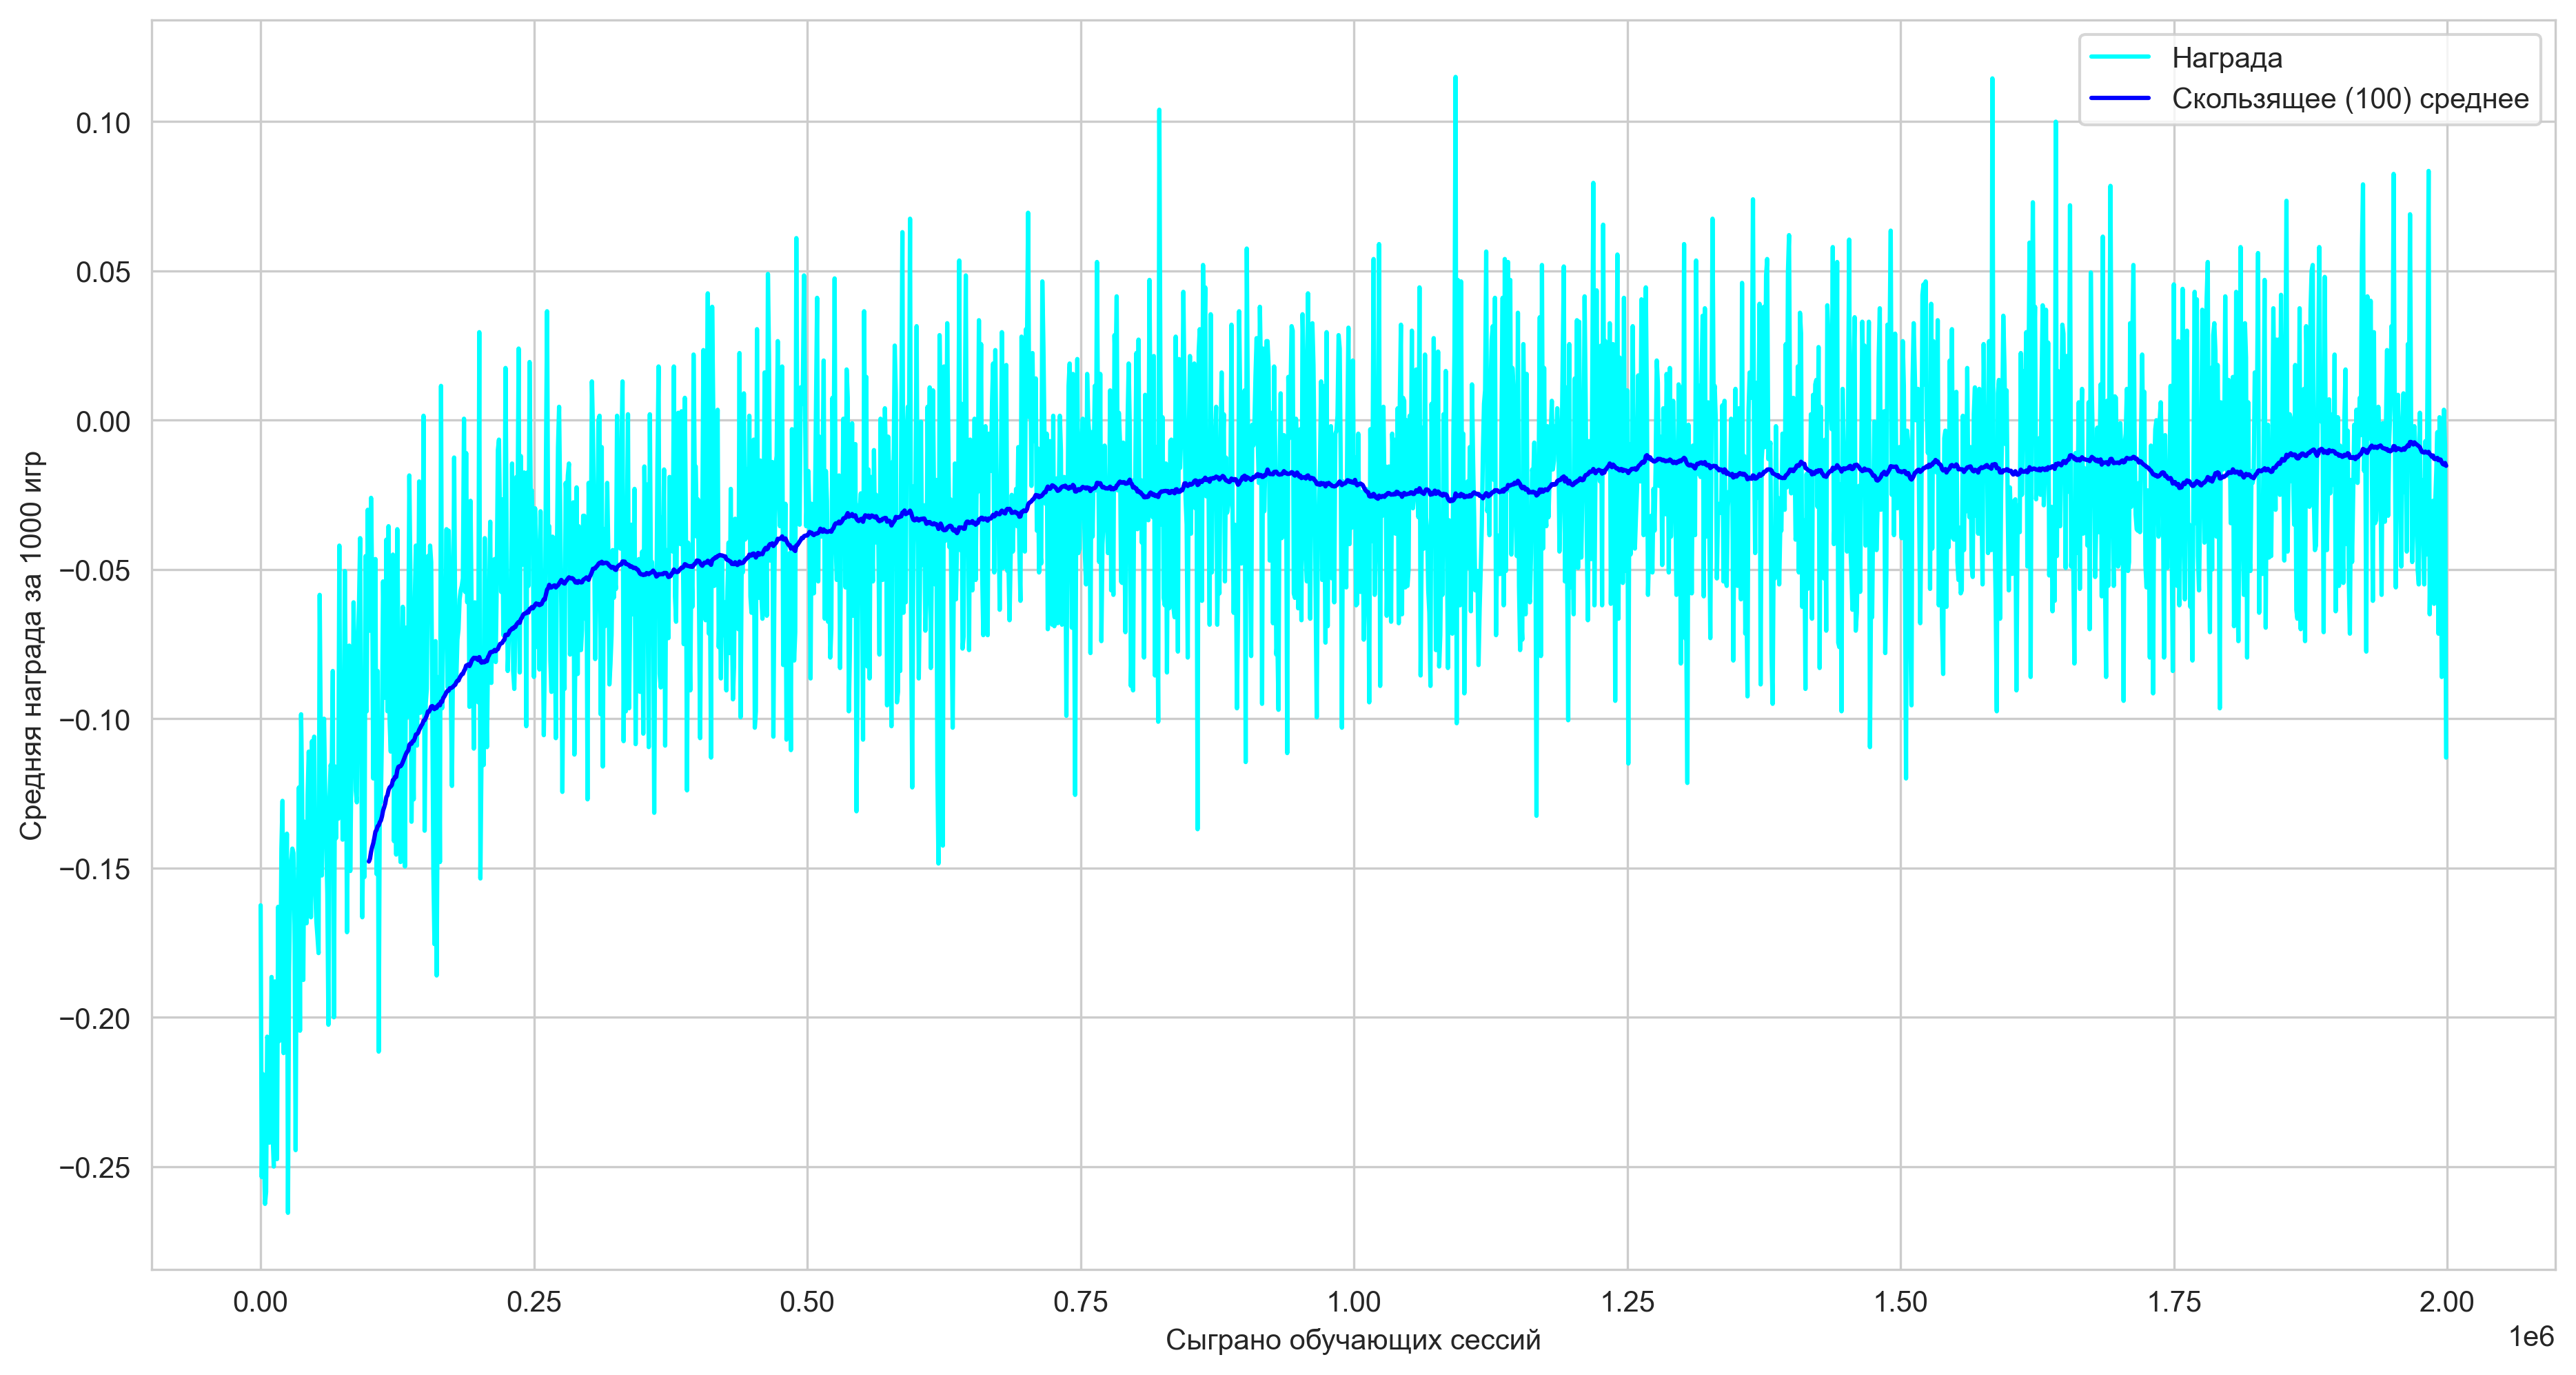

Финальная награда обученного агента равна -0.010 за 10000 игр


In [52]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackCountEnv(natural=True, double=True)

total_episodes = 2_000_000
gamma = 1
eps = 0.95
alpha = 0.001

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=100)

res = np.mean(sample_games(agent, num_games=num_games_outer, env=env))
print(f"Финальная награда обученного агента равна {res:.3f} за {num_games} игр")

env.close()